# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [8]:
random_state = 42 # Для воспроизводимости
n_trials = 20 # Количество попытои при поиске гиперпараметров

In [9]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

from sklearn import metrics

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_validate, KFold, LeaveOneOut, train_test_split
from sklearn.pipeline import Pipeline

import warnings
warnings.simplefilter("ignore")

import optuna

np.random.seed( random_state )

%matplotlib inline

Прочитаем исходные данные:

In [148]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


In [92]:
random_state = 42
n_trials = 20

In [147]:
#######################################################################################
#
# Расчитывает по сериям истинных и предсказанных ответов метрики MAE и MAPE и возвращает кортеж с ними
#
# Вход:
#   y, y_pred - Серии истинных и предсказанных ответов
#
#######################################################################################
def calc_metrics( y, y_pred ):
    return (
        metrics.mean_absolute_error( y, y_pred ),
        metrics.mean_absolute_percentage_error( y, y_pred )
    )


#######################################################################################
#
# Печатает метрики MAE и MAPE 
#
# Вход:
#   hdr - Заголовок
#   mae_score  - метрика MAE
#   mape_score - метрика MAPE
#
#######################################################################################
def print_metrics( hdr, mae_score, mape_score ):
    print( f'{hdr}, MAE: {mae_score:.3f} млн кубических футов газа в день, MAPE: {mape_score * 100:.0f} %')
    

#######################################################################################
#
# Расчитывает по сериям истинных и предсказанных ответов метрики MAE и MAPE и печатает их
#
# Вход:
#   hdr - Заголовок
#   y, y_pred - Серии истинных и предсказанных ответов
#
#######################################################################################
def print_metrics_clc( hdr, y, y_pred ):
    mae_score, mape_score = calc_metrics( y, y_pred )
    print_metrics( hdr, mae_score, mape_score )
     

#######################################################################################
#
# Печатает график с помощью столбчатых диаграмм (barplot) 
#
# Вход: 
#   df        - Серия данных
#   precision - Точность окрегления (знаков после запятой)
#   header    - Заголовок отчета
#   label_x   - Подпись по оси x
#   label_y   - Подпись по оси y
#
#######################################################################################
def plot_barplot_one( df, precision,  header, label_x, label_y = 'Корреляция с целевым признаком' ):
    
    # Строим столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    fig, axes = plt.subplots(  figsize=(8, 5)) #  фигура + координатная плоскость
    sns.barplot( data = df.round( precision ) )
    axes.set_title( header ) # Заголовок отчета
    axes.set_xlabel( label_x )  # Подпись по оси x
    axes.set_ylabel( label_y )  # Подпись по оси y
    for container in axes.containers: # подписывает величины
        axes.bar_label(container)

    plt.show() # Отображаем

    
#######################################################################################
#
# Печатает 2 графика с помощью тепловых карт (heatmap) 
#
# Вход: 
#   data1, data2 - Датафреймы с данными
#   hdr1, hdr1   - Заголовки отчетов 1 и 2
#   accurency    - Точность округления
#
#######################################################################################
def print_heatmap_two( data1, data2, hdr1, hdr2, accurency = 2 ):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title( hdr1)
    sns.heatmap( data1, annot=True, ax=axes[0], fmt = f'.{accurency}f' )
    axes[1].set_title( hdr2 )
    sns.heatmap( data2, annot=True, ax=axes[1], fmt = f'.{accurency}f' )
    
    plt.show()  


#######################################################################################
# 
# Печатаем матрицу корреляции в виде 2х отчетов - тепловай карты (все со всеми) и корреляцию с целевым признаком
#
#######################################################################################
def print_corr_two( arr_corr ):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    print( f"Детерминант матрицы массива датафрейма = {np.linalg.det( arr_corr ):.10f}" )
    print( f"Ранг матрицы массива датафрейма = {np.linalg.matrix_rank( arr_corr )}" )

    axes[0].set_title('Корреляция по всем признакам')
    sns.heatmap(arr_corr, annot=True, ax=axes[0])
    
    sns.barplot( arr_corr['Prod'], ax = axes[1] )
    axes[1].set_title('Корреляция c целевым признаком Prod' )
    
    for container in axes[1].containers: # подписывает величины
        axes[1].bar_label(container)
    
    plt.show() 


#######################################################################################
#
# Выводит столбчатыми диаграммами 2 графика на листе
#
# Вход: 
#   df1, df2   - Серии данных
#   hdr1, hdr2 - Заголовки отчетов 1 и 2
#   label_x1, label_x2 - Подписи по оси x отчетов 1 и 2
#   label_y1, label_y2 - Подписи по оси y отчетов 1 и 2
#
#
############################################1##########################################
def plot_barplot_two( df1, df2, hdr1, hdr2, label_x1, label_x2, label_y1, label_y2):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].set_title( hdr1 )
    axes[0].set_xlabel( label_x1 )
    axes[0].set_ylabel( label_y1 )    
    
    axes[1].set_title( hdr2 )
    axes[1].set_xlabel( label_x2 )
    axes[1].set_ylabel( label_y2 )    

    sns.barplot( df1, ax = axes[0] )
    sns.barplot( df2, ax = axes[1] )
    
    for ind in [0,1]: # Отчеты 0 и 1
        for container in axes[ind].containers: # подписывает величины
            axes[ind].bar_label(container)
    
    plt.show() # Отображаем


#######################################################################################
#
# Расчитывает и печатаем матрицу корреляции в виде 2х отчетов - тепловай карты (все со всеми) и корреляцию с целевым признаком
#
# Вход: 
#   df - Датафрейм 
# Выход:
#   датафрейм матрицы корреляции
#
#######################################################################################
def print_corr_two_df( df ):
    df_corr = df.corr(numeric_only = True, method = 'pearson').round(2)
    print_corr_two( df_corr )
    return df_corr


#######################################################################################
#
# Расчитывает матрицу корреляций Спирмена и выводит ее в виде тепловой карты и печатает текстом ранг и детерминант мтриы корреляции
#
# Вход: 
#   df  - Датафрейм с метриками
#   hdr - Заголовк отчета
# Выход:
#   датафрейм матрицы корреляции
#
#######################################################################################
def print_corr_one( df, hdr ):
    arr_corr = df.corr(numeric_only=True, method='pearson').round(2)
    print( f"Детерминант матрицы массива датафрейма = {np.linalg.det( arr_corr ):.10f}" )
    print( f"Ранг матрицы массива датафрейма = {np.linalg.matrix_rank( arr_corr )}" )

    fig = sns.heatmap(arr_corr, annot=True )
    fig.set_title( hdr )
    plt.show()
    return arr_corr


#######################################################################################
#
# Создает модель линейной регрессии МНК матричным способом
#
# Вход: 
#   X,y       - Датафрейм с признаками и Серия с ответами
#   accuracy  - Точность округления
# Выход:
#   Серия коэффициентов линейной регрессии
# 
#######################################################################################
def LinearRegression_matrix( X, y, accuracy = 0 ):
    cols = X.columns.to_list()
    # Добавляем вектор к таблице первым столбцом
    A = np.column_stack( (np.ones(X.shape[0]), X[cols]) )   
    #Вычисляем вектор коэффициентов
    w = (np.linalg.inv( A.T @ A ) @ A.T @ y).round( accuracy )
    
    tmp_df = pd.Series( w, index = np.append( np.array( ['w0'] ), cols ) )
    return tmp_df


#######################################################################################
#
# Создает модель линейной регрессии МНК матричным способом со стандартизированными факторами
#
# Вход: 
#   X,y       - Датафрейм с признаками и Серия с ответами
#   accuracy  - Точность округления
# Выход:
#   Кортеж (матрица Грамма, cерия коэффициентов линейной регрессии)
#
#######################################################################################
def LinearRegression_matrix_norm( X, y, accuracy = 0 ):
    cols = X.columns.to_list()
    # составляем матрицу А и вектор целевой переменной
    A = X[cols].copy()
    A = A - np.mean( A, axis = 0 ) 
    A = A / np.linalg.norm( A, axis = 0 )
    
    y = y - np.mean( y )
    y = y / np.linalg.norm( y )

    # Вычислим OLS-оценку для коэффициентов
    gr = A.T @ A
    # Вычисляем вектор коэффициентов
    w = (np.linalg.inv( gr ) @ A.T @ y).round( accuracy ).values

    tmp_df = pd.Series( data = w, index = cols )  
    return (gr, tmp_df)

        
#######################################################################################
#
# Возвращает полиномиальные признаки степени degree из датафрейма X со стандартизацией
#
# Вход: 
#   X            - Датафрейм с признаками
#   degree       - Степень полинома
#   include_bias - Включать или нет в выходной датасет столбец с единицами
#   f_prn        - Признак вывода размера полиномиальных признаков
# Выход:
#   Датафрейм с полиномиальными признаками
#
#######################################################################################      
def get_polynom_prz( X, degree = 3, include_bias = False, f_prn = True):
    # Создаем и обучаем пайплайн с StandardScaler, PolynomialFeatures
    pipeline = Pipeline(
        [
            ('StandardScaler', StandardScaler()),
            ('PolynomialFeatures', PolynomialFeatures(degree = degree, include_bias = include_bias)),
        ]
    )
    
    X_scalled_poly = pipeline.fit_transform( X )
    
    if f_prn:
        print( f'X_scalled_poly.shape: {X_scalled_poly.shape}, признаков: {X_scalled_poly.shape[1]}' )
    
    return pd.DataFrame( data = X_scalled_poly )


#######################################################################################
#
# Запускает кросс-валидацию модели без подбора гиперпараметров, обучает модель на обучающих фолдах и возвращает метрики MAE и MAPE обучающей и тестовой наборов
#
# Вход: 
#   model - Модель 
#   X     - Датафрейм с факторами
#   y     - Серия ответов
#   make_degree_koeff - Если True и degree > 1, то расчет новых полиномиальных признаков из X
#   degree - Степень полиномиальных признаков
# 
# Выход:
#   Словарь с вычисленными полиномиальными признаками, коэффициентами модели, метрики
# 
#######################################################################################
def polynomial_regression_sk_full_cv( model, X, y, make_degree_koeff = True, degree = 3 ):
    if make_degree_koeff and degree > 1:
        X_scalled_poly = get_polynom_prz( X, degree = degree, include_bias = False, f_prn = False )
    else:
        X_scalled_poly = X

    # Набор данных невелик, идеален для такого случая LeaveOneOut
    cv = LeaveOneOut()
        
    train_metrics_MAE = []
    test_metrics_MAE = []
    train_metrics_MAPE = []
    test_metrics_MAPE = []
    
    for train_index, test_index in cv.split( X_scalled_poly ):
        # Формируем обучающую и тестовую выборки 
        X_train_cv = X_scalled_poly.iloc[train_index]
        X_test_cv = X_scalled_poly.iloc[test_index]
        y_train_cv = y.iloc[train_index]
        y_test_cv = y.iloc[test_index]
        
        # Обучаем на фолде
        model.fit( X_train_cv, y_train_cv )
        
        # Делаем предсказание для каждой из выборок
        y_train_pred_cv = model.predict( X_train_cv )
        y_test_pred_cv = model.predict( X_test_cv )
        
        # Рассчитываем метрики и заносим их в список
        train_metrics_MAE.append( metrics.mean_absolute_error( y_train_cv, y_train_pred_cv ) )
        train_metrics_MAPE.append( metrics.mean_absolute_percentage_error( y_train_cv, y_train_pred_cv ) )
        test_metrics_MAE.append( metrics.mean_absolute_error( y_test_cv, y_test_pred_cv ) )
        test_metrics_MAPE.append( metrics.mean_absolute_percentage_error( y_test_cv, y_test_pred_cv ) )

    return (
        X_scalled_poly, 
        model.coef_, model.intercept_,
        {
            'fold_MAE_Train': round( np.mean(train_metrics_MAE), 3),
            'fold_MAE_Test': round( np.mean(test_metrics_MAE), 3),
            'fold_MAPE_Train': round( np.mean(train_metrics_MAPE) * 100, 0),
            'fold_MAPE_Test': round( np.mean(test_metrics_MAPE) * 100, 0),
        }
    )


#######################################################################################
#
# Полиморфный обработчик при поиске гиперпараметров optuna
# В качестве объекта кросс-валидации используется LeaveOneOut, т.к. набор данных заказчика очень мал,
#
# Вход: 
#   trial  - Попытка
#   args   - Параметры подбора модели
#
# Выход:
#   Список с усредненными метриками по фолдам для заданного значения гипрпараметров
#
#######################################################################################
def optuna_rf( trial, **args ):
    # задаем пространства поиска гиперпараметров
    items_list = list(args.items())
    
    # Извлекаем из словаря датасеты признаков и ответов
    X_tmp = items_list[0][1]
    y_tmp = items_list[1][1]
    # Извлекаем функцию callback (для универсальности) с настройками гипрпараметров
    fn_cfg_model_callback = items_list[2][1]
    # Извлекаем функцию словарь с параметрами для call-back функции (для универсальности)
    args_f = items_list[3][1]
    # Создает модель нужного типа
    model = fn_cfg_model_callback( trial, args_f )

    # Списки метрик тестового и обучающего набора
    train_metrics_MAE = []
    test_metrics_MAE = []
    train_metrics_MAPE = []
    test_metrics_MAPE = []
    
    # Набор данных невелик, идеален для такого случая LeaveOneOut
    cv = LeaveOneOut()
    for i, (train_index, test_index) in enumerate( cv.split( X_tmp ) ):
        # Формируем обучающую и тестовую выборки 
        X_train_cv = X_tmp.iloc[train_index]
        X_test_cv = X_tmp.iloc[test_index]
        y_train_cv = y_tmp.iloc[train_index]
        y_test_cv = y_tmp.iloc[test_index]
        
        # Обучаем на фолде
        model.fit( X_train_cv, y_train_cv )
        
        # Делаем предсказание для каждой из выборок
        y_train_pred_cv = model.predict( X_train_cv )
        y_test_pred_cv = model.predict( X_test_cv )
        
        # Рассчитываем метрики и заносим их в список
        train_metrics_MAE.append( metrics.mean_absolute_error( y_train_cv, y_train_pred_cv ) )
        train_metrics_MAPE.append( metrics.mean_absolute_percentage_error( y_train_cv, y_train_pred_cv ) )
        test_metrics_MAE.append( metrics.mean_absolute_error( y_test_cv, y_test_pred_cv ) )
        test_metrics_MAPE.append( metrics.mean_absolute_percentage_error( y_test_cv, y_test_pred_cv ) )

    # Сохраним усредненные метрики
    trial.set_user_attr("train_metrics_MAE", np.mean( train_metrics_MAE )  )     
    trial.set_user_attr("train_metrics_MAPE", np.mean( train_metrics_MAPE )  )     
    trial.set_user_attr("test_metrics_MAE", np.mean( test_metrics_MAE )  )     
    trial.set_user_attr("test_metrics_MAPE", np.mean( test_metrics_MAPE )  )     
    
    return np.mean( train_metrics_MAE )    


#######################################################################################
#
# Запускает кросс-валидацию модели с подбором гиперпараметров, обучает модель на обучающих фолдах и возвращает объект с лучшим набором гиперпараметров
#
# Вход: 
#   study_name - Имя модели
#   X     - Датафрейм с факторами
#   y     - Серия ответов
#   cfg_model_callback - callback Функция, возвращающая проинициализированную модель нужного типа с параметрами cfg_model_callback_params
#   cfg_model_callback_params - параметры для callback aeyrwbb
#   n_trials - Количество попыток
# 
# Выход:
#   Объект с лучшим набором гиперпараметров
# 
#######################################################################################
def polynomial_regression_sk_full_cv_hp( study, study_name, X, y, cfg_model_callback, cfg_model_callback_params, n_trials = 5 ):
    # cоздаем объект исследования с целью минимизации
    if study is None:
        study = optuna.create_study( study_name = study_name, direction = "minimize" )
    # Запускаем поиск гиперпараметров
    study.optimize(lambda trial: optuna_rf( trial, X_scalled_poly = X, y = y, cfg_model_callback = cfg_model_callback, cfg_model_callback_params = cfg_model_callback_params ), n_trials = n_trials )
    
    print('------------------------------')
    display( pd.DataFrame(
            data = {
                "train_metrics_MAE": [study.best_trial.user_attrs['train_metrics_MAE']],
                "test_metrics_MAE": [study.best_trial.user_attrs['test_metrics_MAE']],
                "train_metrics_MAPE": [study.best_trial.user_attrs['train_metrics_MAPE'] * 100],
                "test_metrics_MAPE": [study.best_trial.user_attrs['test_metrics_MAPE'] * 100],
                "best_params": [study.best_params],
            }
        )
    )

    return study


#######################################################################################
# 
# 1) Формирует полиномиальные признаки степени degree_max (для 2 и более) из датафрейма признаков X
# 2) Обучает модель линейной регрессии на полученных признаках с помощью фолдов
# 3) Расчитывает метрики MAE и MAPE и выводит их в графическом виде метрики в зависимости от степени
#
# Вход: 
#   X - Датафрейм с факторами
#   y - Серия ответов
#   degree_max - Степень полинома
#
#######################################################################################
def plot_metrics_degree( X, y, degree_max = 5 ):

    tmp_df = pd.DataFrame( columns = ['MAE train','MAE test','MAPE train','MAPE test', 'Детерминант Пирсона', 'Ранг', 'К-во признаков'] )

    for degree in range( 1, degree_max + 1 ):
        print( f"Вычисляем степень полинома: {degree}, обучаем модель на фолдах и получаем метрики" )
        model = LinearRegression( fit_intercept = True ) # w0 создаст сама функция
        # Расчитаем полиномиальные признка степени degree,обучим модель и получим метрики фолдов
        X_scalled_poly, _, _, arr_scores = polynomial_regression_sk_full_cv( model, X, y, make_degree_koeff = True, degree = degree)
        tmp_df_corr = X_scalled_poly.corr()
        det_train = np.linalg.det( X_scalled_poly.corr() )
        rank_train = np.linalg.matrix_rank( tmp_df_corr )
        
        tmp_df.loc[degree] = [ 
                arr_scores['fold_MAE_Train'], arr_scores['fold_MAE_Test'], 
                arr_scores['fold_MAPE_Train'], arr_scores['fold_MAPE_Test'], 
                det_train, rank_train, X_scalled_poly.shape[1]
            ]

    display( tmp_df )

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    # Строим график MAE в зависимости от степени полинома
    axes[0].plot( tmp_df.index, tmp_df["MAE train"], label="MAE train")
    axes[0].plot( tmp_df.index, tmp_df["MAE test"], label="MAE test")

    # Подписи заголовка и осей
    axes[0].set_title("Метрика MAE")
    axes[0].set_xlabel("Степень полинома")
    axes[0].set_ylabel("MAE, млн кубических футов газа в день")

    # Отображаем легенду
    axes[0].legend()

    # Строим график MAPE в зависимости от степени полинома
    axes[1].plot( tmp_df.index, tmp_df["MAPE train"], label="MAPE train")
    axes[1].plot( tmp_df.index, tmp_df["MAPE test"], label="MAPE test")

    # Подписи заголовка и осей
    axes[1].set_title("Метрика MAPE")
    axes[1].set_xlabel("Степень полинома")
    axes[1].set_ylabel("MAPE, %")
    
    # Отображаем легенду
    axes[1].legend()

    plt.show()
    

#######################################################################################
# 
# Отобразим графически гистограмму распределения и зависимости факторов с целевым признаком.
# Вход: 
#   df - Датафрейм
#
#######################################################################################
def plot_df_histplot( df ):
    # Выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
    types = df.dtypes
    cols = list(types[(types != 'object')].index)

    n = len( cols ) # Количество числовых признаков
    fig, axes = plt.subplots(n, 2, figsize=(15, 30)) # фигура + n х 2 координатных плоскостей
    # Создаем цикл для всех признаков из списка числовых признаков
    for i, feature in enumerate(cols): # i- индекс, feature - название признака в таблице
        # Строим гистограмму распределения признака 
        histplot = sns.histplot( data = df, x = feature, ax = axes[i][0])
        # Добавляем подпись графику
        histplot.set_title( f'Распределение признака {feature}')
        # Добавляем поворот отметок на оси абсцисс
        histplot.xaxis.set_tick_params( rotation = 45)
        # Строим диаграмму рассеяния + линейную регрессию
        regplot = sns.regplot( data = df, x = feature, y = 'Prod', ax = axes[i][1] )
        # Добавляем подпись графику
        regplot.set_title( f'Корреляция признака {feature} с целевым признаком Prod' );
        # Добавляем поворот отметок на оси абсцисс
        regplot.xaxis.set_tick_params( rotation = 45 )
    plt.tight_layout() # выравнивание графиков
    

#######################################################################################
# 
# Отобразим графически коробчатую диаграмму и зависимости факторов с целевым признаком.
# Вход: 
#   df - Датафрейм
#
#######################################################################################
def plot_df_boxplot( df ):
     # Выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
    types = df.dtypes
    cols = list(types[(types != 'object')].index)

    n = len( cols ) # Количество числовых признаков
    fig, axes = plt.subplots(n, 2, figsize=(15, 30)) # фигура + n х 2 координатных плоскостей
    # Создаем цикл для всех признаков из списка числовых признаков
    for i, feature in enumerate(cols): # i- индекс, feature - название признака в таблице
        # Строим гистограмму распределения признака 
        histplot = sns.boxplot( data = df, x = feature, orient ='h', width = 0.9, ax = axes[i][0])
        # Добавляем подпись графику
        histplot.set_title( f'Распределение признака {feature}')
        # Добавляем поворот отметок на оси абсцисс
        histplot.xaxis.set_tick_params( rotation = 45)
        
        # Строим диаграмму рассеяния + линейную регрессию
        regplot = sns.regplot( data = df, x = feature, y = 'Prod', ax = axes[i][1] )
        # Добавляем подпись графику
        regplot.set_title( f'Корреляция признака {feature} с целевым признаком Prod' );
        # Добавляем поворот отметок на оси абсцисс
        regplot.xaxis.set_tick_params( rotation = 45 )
    plt.tight_layout() # выравнивание графиков

## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [151]:
# Ваш код здесь
display( data.describe() )
display( data.info() )

print( 'Выбросы' )
display( data[data['TOC'] <= 0] )

df = data.copy()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


None

Выбросы


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
25,26,7.27,2.01,3.41,54.56,-0.04,1.68,2351.289487
42,43,10.14,3.78,4.26,61.89,-0.19,1.97,3098.436639
179,180,7.22,1.42,3.60,63.09,-0.03,1.67,2362.269336
197,198,12.12,2.27,3.52,57.07,-0.04,1.73,3409.575363


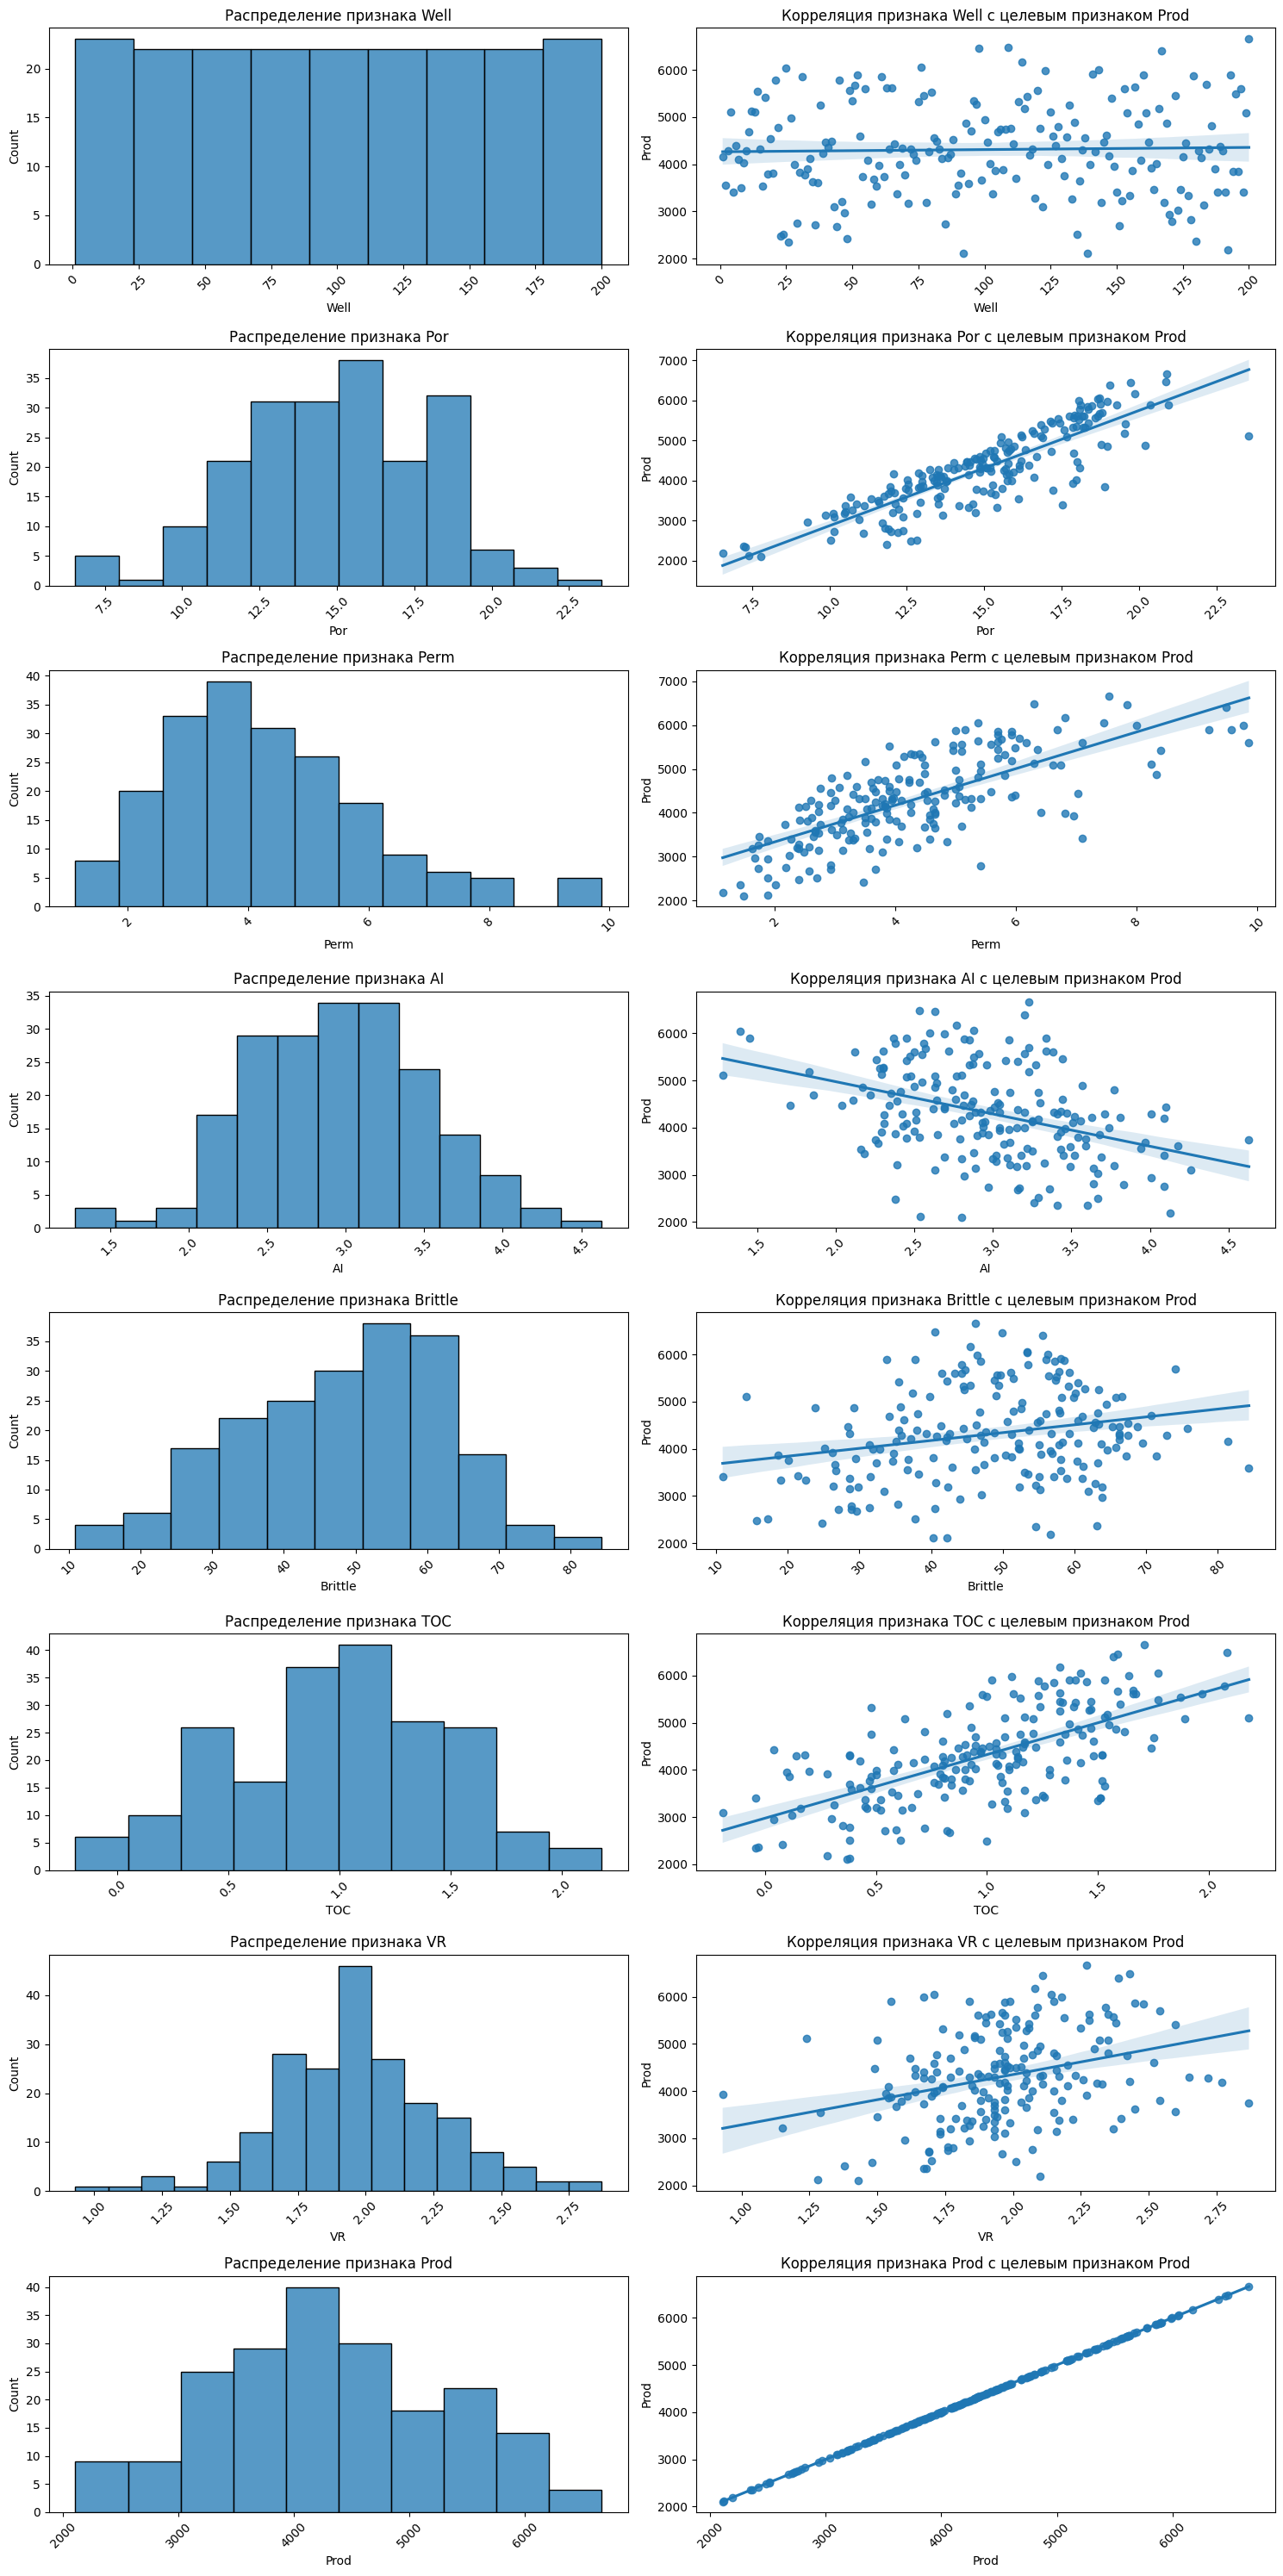

In [152]:
plot_df_histplot( df )

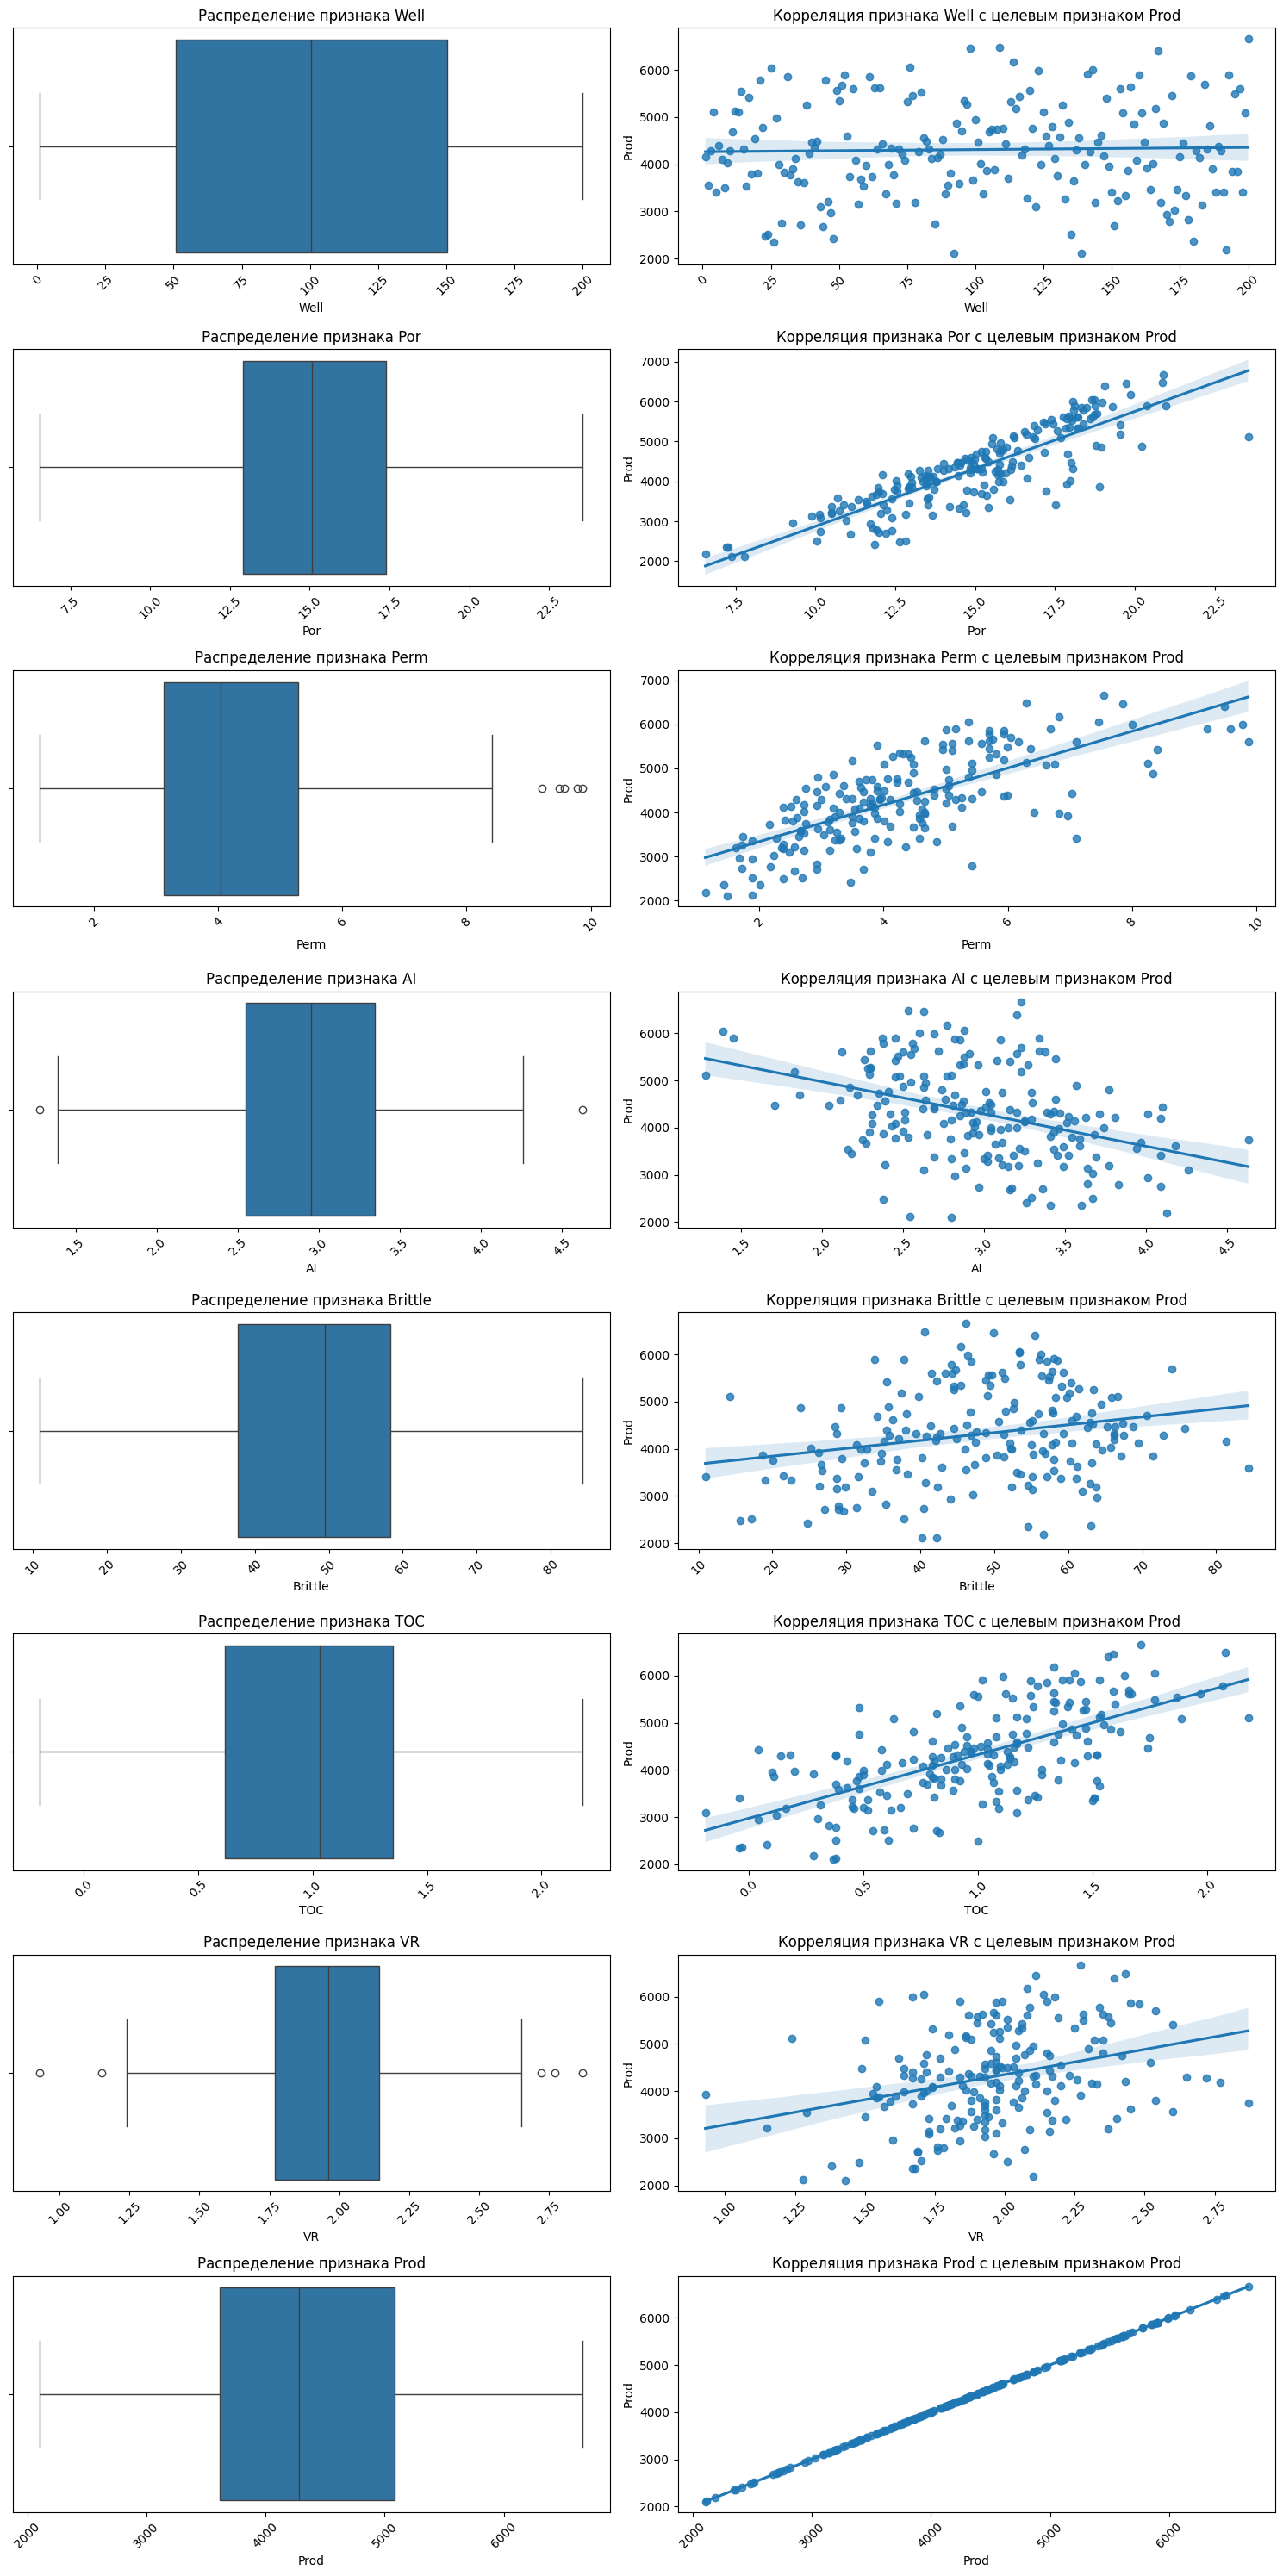

In [153]:
plot_df_boxplot( df )

Все данные - числовые, пропусков не обнаружено, имеются выбросы (4 наблюдения с отрицательным признаком TOC), но данных мало - не трогаем их.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Детерминант матрицы массива датафрейма = 0.0007480083
Ранг матрицы массива датафрейма = 8


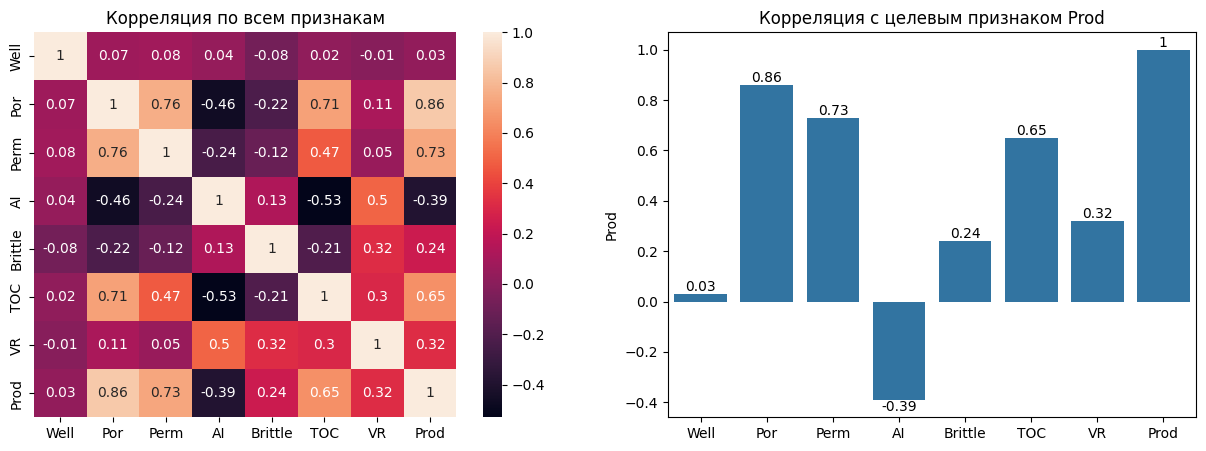

In [58]:
# Ваш код здесь
df_corr = print_corr_two_df( df )

1) Ранг максимальный, но матрица близка к вырожденной (детерминант около 0). Но это ничего еще не значит. С целевым признаком сильно коррелируют другие признаки, эти сочетания вносят вклад в устремление детерминанта к нулю.
2) Есть корреляция между факторами (Por,Perm), (Por,TOC)
3) Признак Well ни на что не влияет

Уберем целевой признак

Детерминант матрицы массива датафрейма = 0.0188505262
Ранг матрицы массива датафрейма = 7


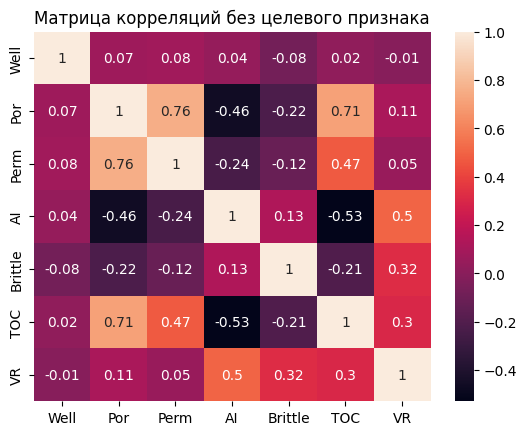

In [59]:
_ = print_corr_one( df.drop( columns = ['Prod'], axis=1 ), hdr = 'Матрица корреляций без целевого признака' )

Теперь остались только корреляции между факторами 
1) Ранг вырос на 2 порядка, но еще близок к нулю
2) Есть корреляция между факторами, она и снижает детерминант

Несколько сочетаний. Оставим наиболее значимые признаки

Детерминант матрицы массива датафрейма = 0.9516000000
Ранг матрицы массива датафрейма = 2


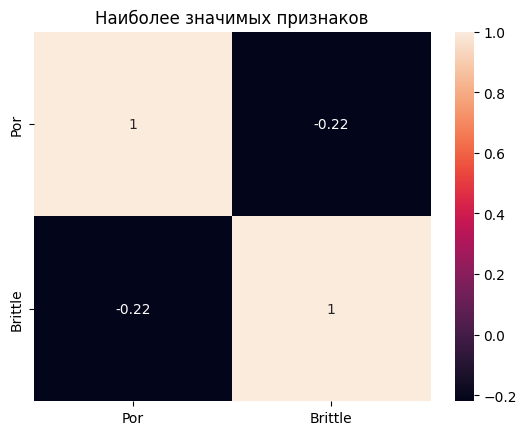

Детерминант матрицы массива датафрейма = 0.7494120000
Ранг матрицы массива датафрейма = 3


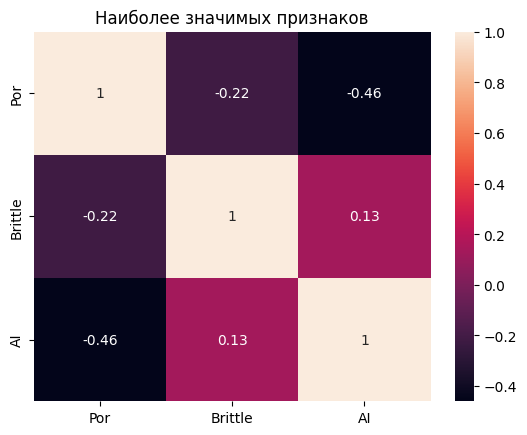

Детерминант матрицы массива датафрейма = 0.3693682500
Ранг матрицы массива датафрейма = 4


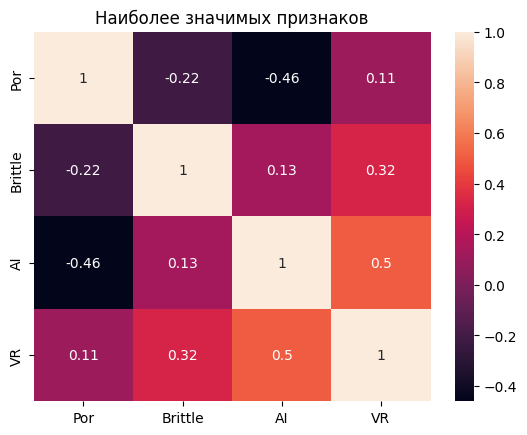

In [60]:
# Матрица корреляций 2х наиболее значимых признаков
_ = print_corr_one( df[ ['Por','Brittle'] ], hdr = 'Наиболее значимых признаков' )

# Матрица корреляций 3х наиболее значимых признаков
_ = print_corr_one( df[ ['Por','Brittle', 'AI'] ], hdr = 'Наиболее значимых признаков' )

# Матрица корреляций 4х наиболее значимых признаков
_ = print_corr_one( df[ ['Por','Brittle', 'AI', 'VR'] ], hdr = 'Наиболее значимых признаков' )

Вырожденность снята

> *Ваши выводы здесь*

1) Фактор Por имеет наиболее сильную корреляцию с целевой переменной.
2) Фактор Rerm тоже имеет сильное влияние на целевую переменную, но из-за сильной корреляции с доминирующим признаком Por я бы исключил его из медели.
3) Фактор TOC имеет среднее влияние на целевую переменную, но из-за сильной корреляции с доминирующим признаком Por я бы исключил его из медели.
4) Также вказывают влияние факторы Al, VR, Brillle (в порядке убывания влияния на целевой признак)
5) Детерминант матрицы корреляции c целевым признаком близок к нулю. Но это не еще говорит о мультиколлинеарности, т.к. в модели есть факторы, сильно коррелирующие с целевым признаком, что и приближает детерминант матрицы к нулю. 
6) Без целевого признака детерминант матрицы корреляции между признаками тоже был близок к нулю. Значит 
   - Это явный признак мультиколлинеарности
   - Результаты регрессии будут не надежны - при добавлении одного нового измерения коэффициенты могут измениться очень сильно, и мы не сможем их корректно интерпретировать.
   - Будут возникать переобучение регрессии: на обучающей выборке ошибка прогноза будет маленькая, а на тестовой — большая.

Такую модель нельзя для прогнозирования. Но если исключить мультиколлинеарность - модель будет жизнеспособна. 

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [63]:
# Ваш код здесь
X = df.drop( ['Prod'], axis = 1 )
y = df['Prod']
print( f'Размерность X: {X.shape}, y: {y.shape}' )

# Строим модель линейной регрессии МНК без стандартизации
df_coeff = LinearRegression_matrix( X, y )
# Строим модель линейной регрессии МНК со стандартизацией
gr_std, df_coeff_std = LinearRegression_matrix_norm( X, y, 2 )

Размерность X: (200, 7), y: (200,)


Проверим корректность нормализаванной модели на навенство матрицы Грамма и корреляции Пирсона

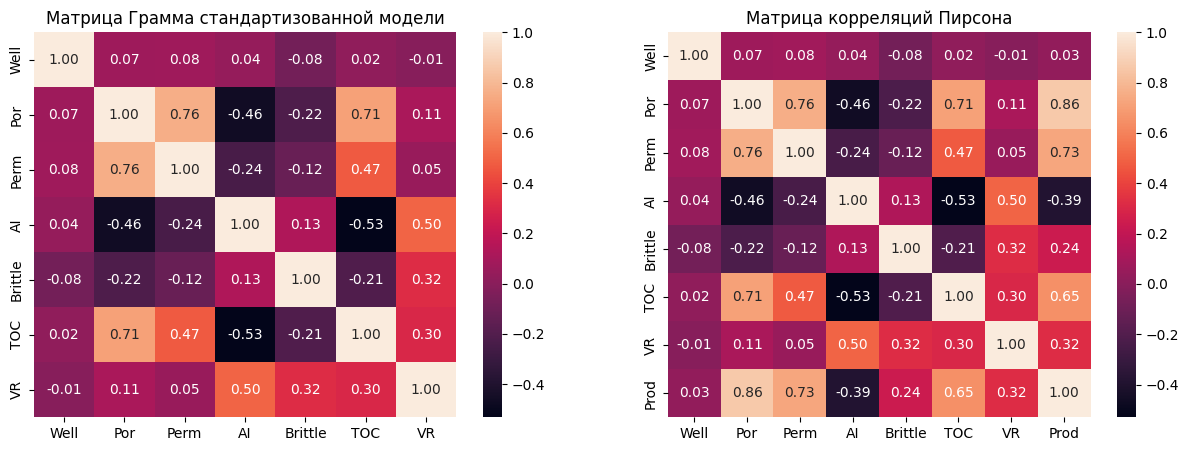

In [64]:
print_heatmap_two( gr_std, df_corr, 'Матрица Грамма стандартизованной модели', 'Матрица корреляций Пирсона' )

Отобразим коэффициенты модели без и со стандартизацией

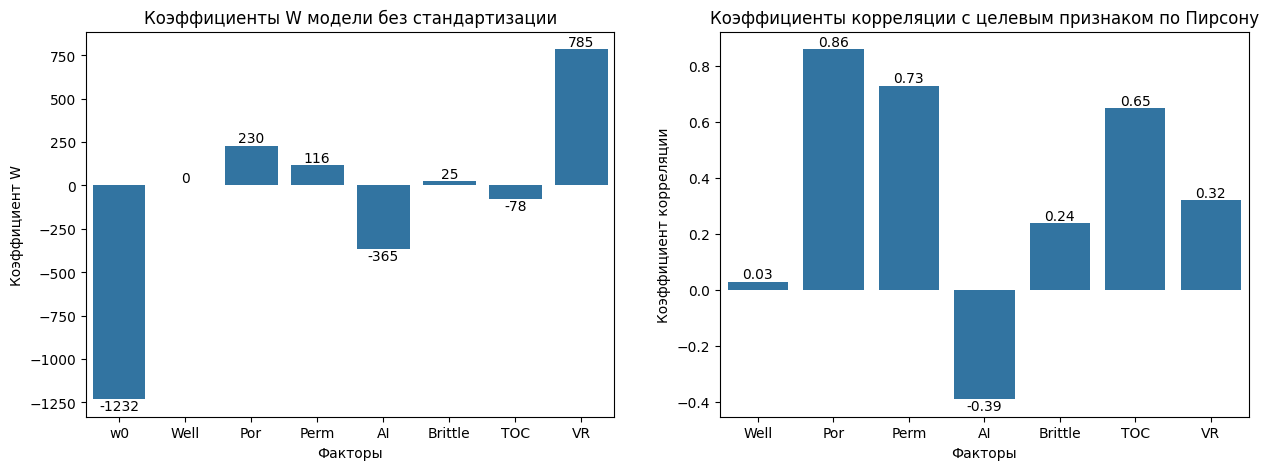

In [65]:
plot_barplot_two( pd.Series( data = df_coeff ), pd.Series( data = df_corr['Prod'].drop( index = 'Prod' )),  "Коэффициенты W модели без стандартизации", "Коэффициенты корреляции с целевым признаком по Пирсону", "Факторы", "Факторы", "Коэффициент W", "Коэффициент корреляции" )

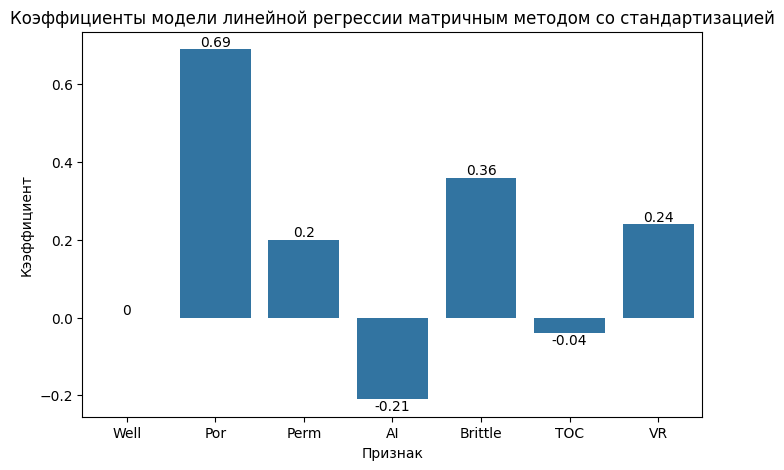

In [66]:
plot_barplot_one( df_coeff_std, 2, header = "Коэффициенты модели линейной регрессии матричным методом со стандартизацией", label_x = "Признак", label_y = 'Кээффициент' )

Видим, что 
1) Модели построены корректно, о чем свидетельствуют равенство матрицы корреляции Пирсона и стандартизованной матрицы Грамма
2) Согласно матрице ковкрреляции
    - Фактор Well не информативен (не влияет на целевой признак), подлежит исключению.
    - Факторы Perm, TOC сильно коррелируют с Por, портят предсказательную силу модели, подлежат исключению.
    - Факторы Por, Btittle, VR, Al  имеют наибольшее влияние на целевой признак и относительно независимы друг от друга, их оставим. 

4) Знак коэффициента влияния параметра TOC на целевой признак в нестандартизованной модели расходится со знаком матрицы Пирсона

Исходя из коэффициентов модели имеем  
1) Увеличение фактора Por на 1%, влечет увеличени добычи газа увеличится на 230 млн м$^3$
2) Увеличение фактора Brittle на 1%, влечет увеличение добычи газа увеличится на 25 млн м$^3$
3) Снижение фактора Al на 1 $кг/м^2 * 10^6$, влечет увеличени добычи газа увеличится на 365 млн м$^3$

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

Для удобства объяснения клиенту целесобразней выбрать пару дополняющих друг друга метрик MAE+MAPE (вместо всеми любимой, но несколько абстрактной для клиента R2)

In [13]:
# Ваш код здесь
print( 'Сделаем прогноз для скважины 106 и метрики' )
print( '------------------------------------------' )

y_test_one = 4748.315024
X_test_one = pd.Series( {
    'w0': 1,
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
} )

print( X_test_one )
y_pred_one = X_test_one @ df_coeff.values
print_metrics_clc( f'Прогноз скважины 106, Факт: {y_test_one}, предсказано: {y_pred_one}', pd.Series( data = [y_test_one] ), pd.Series( data = [y_pred_one] ) )

print()
print( 'Сделаем прогноз для всех скважин обучающего набора' )
print( '--------------------------------------------------' )
y_pred = np.column_stack( (np.ones(X.shape[0]), X) ) @ df_coeff.values
print_metrics_clc( 'Метрика обучающей выборки', y, y_pred )

Сделаем прогноз для скважины 106 и метрики
------------------------------------------
w0           1.00
Well       106.00
Por         15.32
Perm         3.71
AI           3.29
Brittle     55.99
TOC          1.35
VR           2.42
dtype: float64
Прогноз скважины 106, Факт: 4748.315024, предсказано: 4715.26, MAE score: 33.055 млн кубических футов газа в день
Прогноз скважины 106, Факт: 4748.315024, предсказано: 4715.26, MAPE score: 1 %

Сделаем прогноз для всех скважин обучающего набора
--------------------------------------------------
Метрика обучающей выборки, MAE score: 154.558 млн кубических футов газа в день
Метрика обучающей выборки, MAPE score: 4 %


> *Ваши выводы здесь*

1) Модель отработала в единичном и множественном режиме.
2) В качестве метрик в силу специфики задачи выбраны MAE и MAPE, т.к. 
    - Понятна клиенту - ошибки модели в абсолютных и процентных единицах измерений (не абстрактная R2). 
    - Очень ограниченный набор данных, при измерении метрик на фолдах подходит только LeaveOneOut, а раз метрика вычисляется на одной строке на тестовой выборке, то R2 будет показывать NaN (те R2 не применим еще и технически). Без вариантов MAE+MAPE
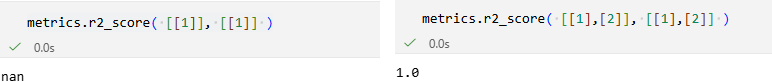
2) Точность модели оказалась не высока, но это мы попраим скоро


### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

Посмотрим графики корреляций и весов коэффициентов

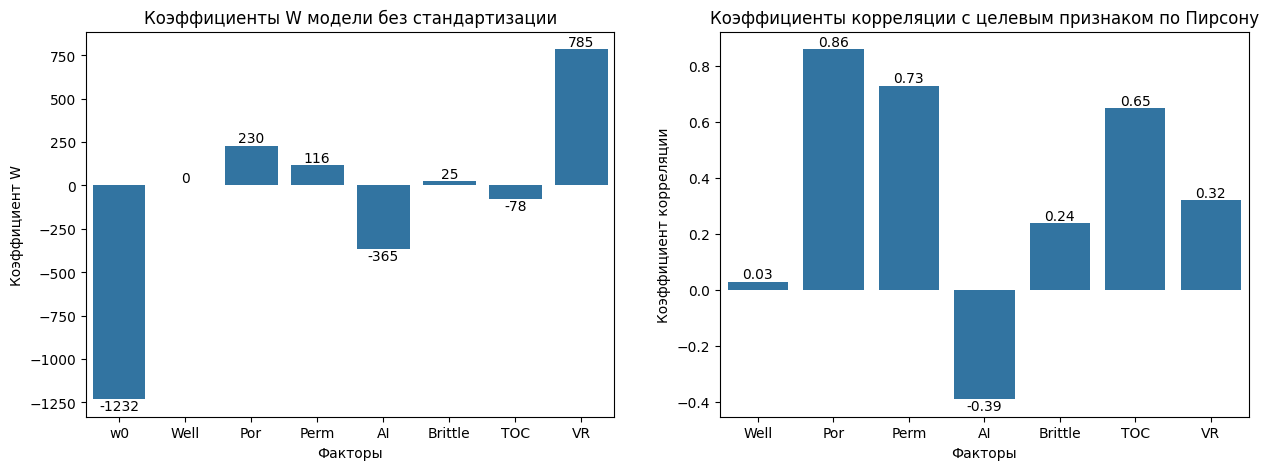

In [1244]:
plot_barplot_two( pd.Series( data = df_coeff ), pd.Series( data = df_corr['Prod'].drop( index = 'Prod' )),  "Коэффициенты W модели без стандартизации", "Коэффициенты корреляции с целевым признаком по Пирсону", "Факторы", "Факторы", "Коэффициент W", "Коэффициент корреляции" )

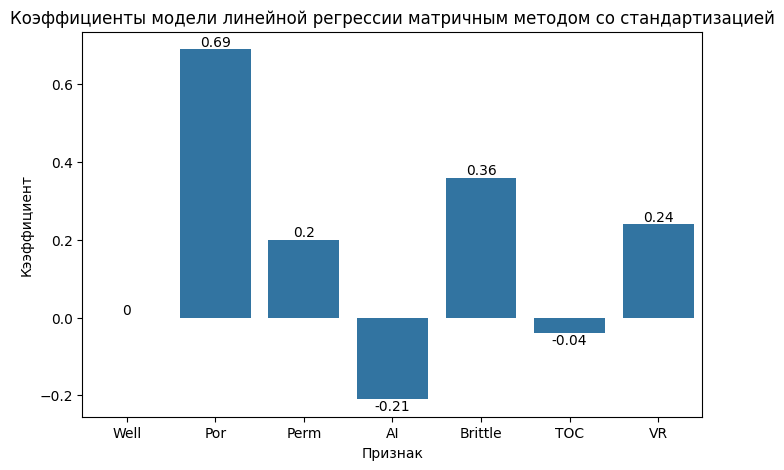

In [67]:
plot_barplot_one( df_coeff_std, 2, header = "Коэффициенты модели линейной регрессии матричным методом со стандартизацией", label_x = "Признак", label_y = 'Кээффициент' )

> *Ваши выводы здесь*

1) Знаки величин матрицы корреляции факторов с целевым признаком совпадает со знаком модели (соонаправленность), на всех факторах, кроме TOC. Разнонаправленность возможно связана с наличием перекрестного взаимного влияния нескольких зависимых факторов в нашем наборе ранных.
2) Значимость фактора VR в модели без стандартизации завышена. Это связано с различием масштабов факторов. В нестандартизованной матричной формуле вес коэффициента обратно пропорционалем детерминанту матрицы наблюдения, а, значит, норме каждого вектора наблюдения. Т.к. среднее значение VR минимально (TOC - особый случай - выбросы), а Britlle - максимальна, то и модель думает, что VR сильнее всего влияет на модель, а Brittle - слабее.


### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [68]:
# Ваш код здесь
cols_del = ['Perm','TOC','Well']
X.drop( columns = cols_del, axis = 1, inplace = True )
df.drop( columns = cols_del, axis = 1, inplace = True )

Смотрим матрицу корреляции обновленного набора данных

Детерминант матрицы массива датафрейма = 0.0204141432
Ранг матрицы массива датафрейма = 5


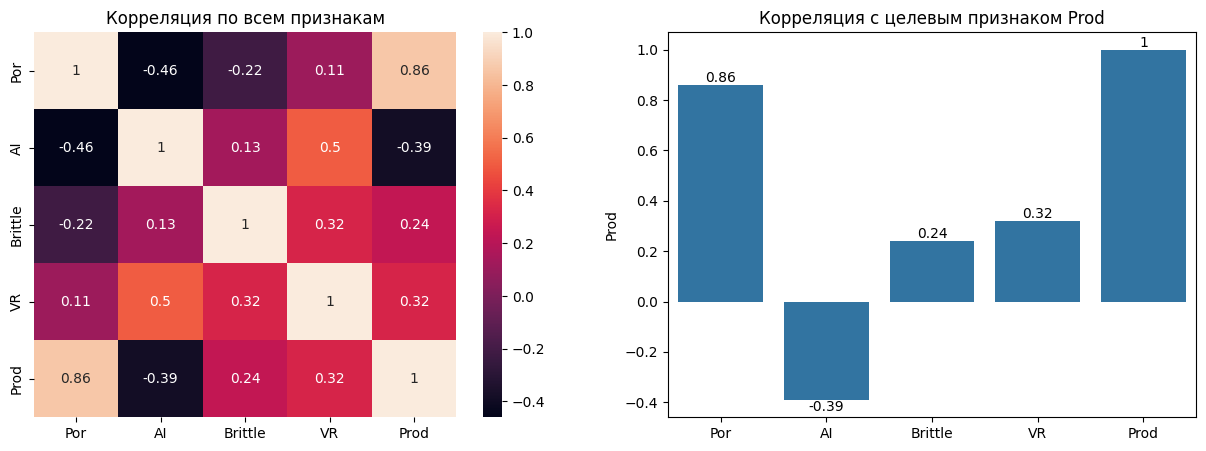

Детерминант матрицы массива датафрейма = 0.3693682500
Ранг матрицы массива датафрейма = 4


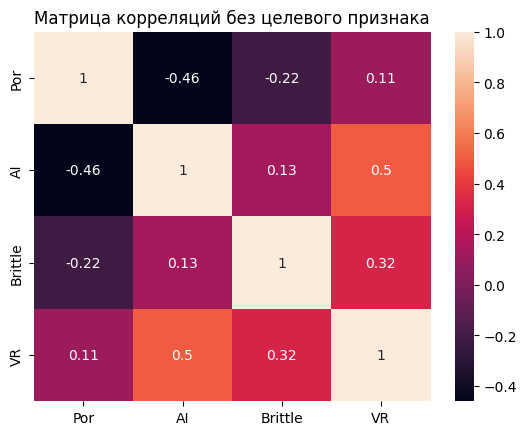

In [69]:
df_corr = print_corr_two_df( df )
_ = print_corr_one( df.drop( columns = ['Prod'], axis=1 ), hdr = 'Матрица корреляций без целевого признака' )

Построим модель без стандартизации

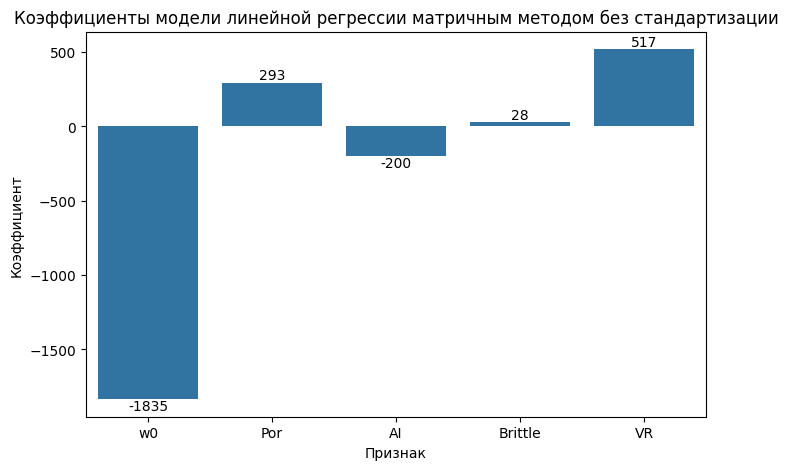

Линейная регрессия, MHK, MAE score: 171.868 млн кубических футов газа в день, , MAPE score: 4 %


In [81]:
df_coeff = LinearRegression_matrix( X, y )
plot_barplot_one( df_coeff, 0, header = "Коэффициенты модели линейной регрессии матричным методом без стандартизации", label_x = "Признак", label_y = 'Коэффициент' )

X_train = np.column_stack( (np.ones(X.shape[0]), X) )  
y_pred = X_train @ df_coeff.values
print_metrics_clc( 'Линейная регрессия, MHK', y, y_pred )

Построим модель со стандартизацией, чтобы оценить реальное влияние факторов на целевую переменную

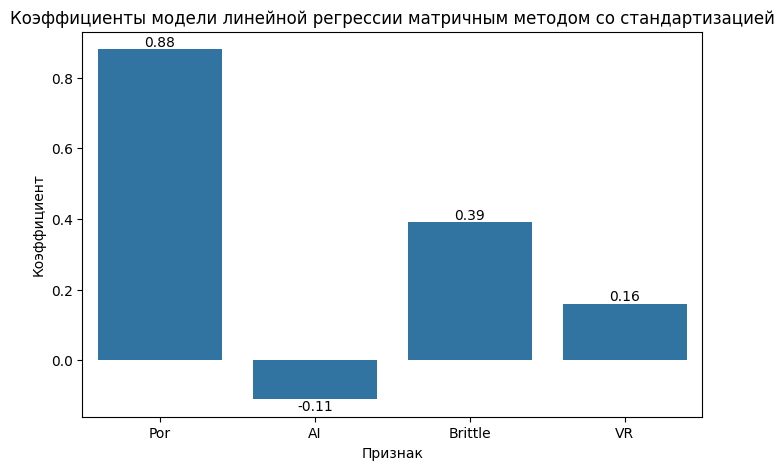

In [71]:
gr_std, df_coeff_std = LinearRegression_matrix_norm( X, y, 2 )
plot_barplot_one( df_coeff_std, 2, header = "Коэффициенты модели линейной регрессии матричным методом со стандартизацией", label_x = "Признак", label_y = 'Коэффициент' )

> *Ваши выводы здесь*


1) Корреляция между факторами увеличилась в 20 раз (и достигла 0.4). Модель стала устойчивее, сингулярность матрицы корреляции признаков преодолена.
2) Соонаправленность знаков величин коэффиентов модели без стандартизации и матрицы корреляции соблюдена. 
3) Хотя метрики MAE, MAPE не улучшились (MAE даже чуть ухудшилась), модель готова к использованию
4) В среднем коэффициенты уменьшились по сравнению с первоначальными величинами. Это еще один стабилизации модели

Исходя из коэффициентов новой модели имеем  
1) Увеличение фактора Por на 1%, влечет увеличени добычи газа увеличится на 293 млн м$^3$
2) Увеличение фактора Brittle на 1%, влечет увеличени добычи газа увеличится на 28 млн м$^3$
3) Снижение фактора Al на 1 $кг/м^2 * 10^6$, влечет увеличени добычи газа увеличится на 200 млн м$^3$



### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

sklearn.linear_model.LinearRegression
-------------------------------------
Коэффициенты [ 293. -200.   28.  517.], w0 = -1835.0
Линейная регрессия, scikit-learn, MAE: 171.431 млн кубических футов газа в день, MAPE: 4 %


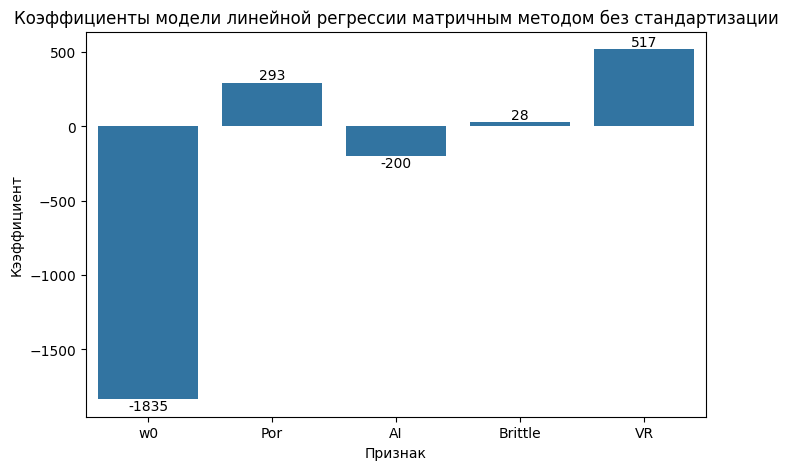

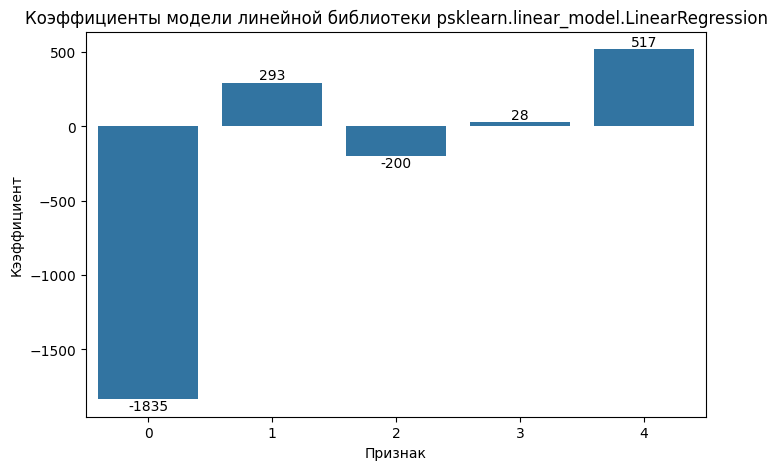

In [85]:
# Ваш код здесь
print( 'sklearn.linear_model.LinearRegression' )
print( '-------------------------------------' )
model = LinearRegression()

# Обучаем модель
model.fit( X, y )
y_pred = model.predict( X )

# Выводим результирующие коэффициенты
print( f'Коэффициенты {model.coef_.round()}, w0 = {model.intercept_.round()}' )
print_metrics_clc( 'Линейная регрессия, scikit-learn', y, y_pred )

plot_barplot_one( df_coeff, 0, header = "Коэффициенты модели линейной регрессии матричным методом без стандартизации", label_x = "Признак", label_y = 'Кээффициент' )
tmp_df = pd.Series( data = np.append( model.intercept_, model.coef_ ), index = ['w0'].append( X.columns.to_list() ) )
plot_barplot_one( tmp_df, 0, header = "Коэффициенты модели линейной библиотеки рsklearn.linear_model.LinearRegression", label_x = "Признак", label_y = 'Кээффициент' )


In [ ]:
# Обучаем модель на фолдах для
_, _, _, arr_scores = polynomial_regression_sk_full_cv( model, X, y, make_degree_koeff = False, degree = 1 )

# Сохраним метрики
train_metrics_MAE_one = arr_scores['fold_MAE_Train']
train_metrics_MAPE_one = arr_scores['fold_MAPE_Train']
test_metrics_MAE_one = arr_scores['fold_MAE_Test']
test_metrics_MAPE_one = arr_scores['fold_MAPE_Test']

display( pd.DataFrame( data = { "MAE Train": [train_metrics_MAE_one], "MAE Test": [test_metrics_MAE_one], "MAPE Train": [train_metrics_MAPE_one], "MAPE Test": [test_metrics_MAPE_one] } ) )

,MAE Train,MAE Test,MAPE Train,MAPE Test
0,171.411,176.693,4.0,4.0


> *Ваши выводы здесь*

Тестирование обоих моделей показало, что
1) Результаты и метрики обоих моделей практически сошлись
2) Коэффициенты тоже сошлись. 

Что говорит о математическом и техническом сходстве обоих методов (как минимум в точках вдали от сингулярности).
Методология построения модели и правильность критериев отброра факторов подтверждена практтически

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

Стандартизируем факторы и генерируем признаки 3й степени

In [86]:
X_scalled_poly = get_polynom_prz( X, degree = 3, include_bias = False, f_prn = False )

Строим модель на полиномиальных коэффициентах 3й степени линейной регрессии

In [87]:
# Создаем модель
model = LinearRegression( fit_intercept = True ) # w0 создаст сама функция

# Обучаем модель на фолдах и смотрим метрики
_, _, _, arr_scores = polynomial_regression_sk_full_cv( model, X_scalled_poly, y, make_degree_koeff = False, degree = 3 )

# обучаем модель
tmp_df_corr = X_scalled_poly.corr()
det_corr = np.linalg.det( X_scalled_poly.corr() )
rank_corr = np.linalg.matrix_rank( tmp_df_corr )

# Сохраним метрики
train_metrics_MAE_poly = arr_scores['fold_MAE_Train']
train_metrics_MAPE_poly = arr_scores['fold_MAPE_Train']
test_metrics_MAE_poly = arr_scores['fold_MAE_Test']
test_metrics_MAPE_poly = arr_scores['fold_MAPE_Test']

display( pd.DataFrame( data = { "MAE Train": [train_metrics_MAE_poly], "MAE Test": [test_metrics_MAE_poly], "MAPE Train": [test_metrics_MAPE_poly], "MAPE Test": [test_metrics_MAPE_poly], "Детерминант Пирсона": [det_corr], "Ранг": rank_corr } ) )

,MAE Train,MAE Test,MAPE Train,MAPE Test,Детерминант Пирсона,Ранг
0,78.54,106.998,3.0,3.0,1.170247e-24,34


Проведем небольшое исследование зависимости разложения степени полинома от метрик MAE и MAPE, чтобы получить предаставление о скорости переобучения

Вычисляем степень полинома: 1, обучаем модель на фолдах и получаем метрики
Вычисляем степень полинома: 2, обучаем модель на фолдах и получаем метрики
Вычисляем степень полинома: 3, обучаем модель на фолдах и получаем метрики
Вычисляем степень полинома: 4, обучаем модель на фолдах и получаем метрики
Вычисляем степень полинома: 5, обучаем модель на фолдах и получаем метрики


,MAE train,MAE test,MAPE train,MAPE test,Детерминант Пирсона,Ранг,К-во признаков
1,171.411,176.693,4.0,4.0,3.682630e-01,4.0,4.0
2,100.960,111.855,2.0,3.0,2.012547e-04,14.0,14.0
3,78.540,106.998,2.0,3.0,1.170247e-24,34.0,34.0
4,61.051,131.558,1.0,3.0,8.499944e-95,69.0,69.0
5,43.638,617.292,1.0,16.0,5.755778e-291,125.0,125.0


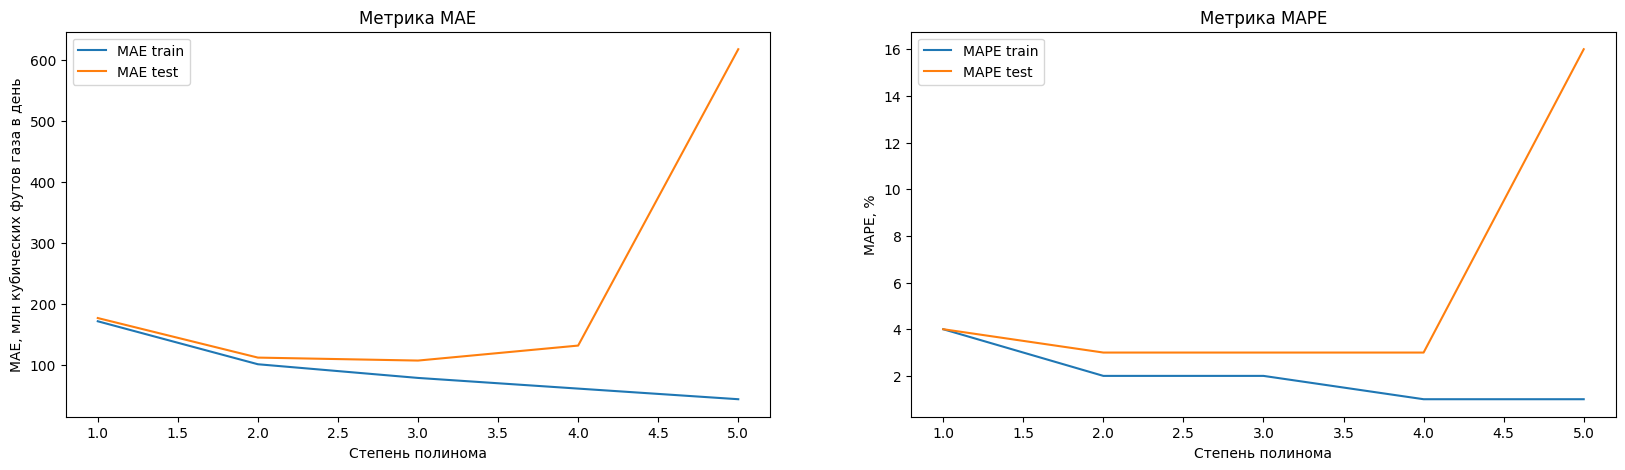

In [90]:
plot_metrics_degree( X, y, degree_max = 5 ) # До полиномов 5й степени

> *Ваши выводы здесь*

Наблюдаем следующее

Для степени 3
1) Метрики значительно лучше, чем для 1 степени
2) Есть переобучение
3) Детерминант матрицы корреляций Спирмена близок к нулю. Используется сингулярное разложение, модель не надежна

В целом
1) Начиная со степени 3 наблюдается переобучение модели. Для степеней 2 и 3 оно еще не значительно, но начиная с 4х, разница метрик растет ускоренно. 
2) На признаках 1 степени почти нет расхождения метрик, как на фолдах, так и в целом. Зато плохие показатели метрик (недообучение)
3) Начиная со степени 3 и выше детерминант матрицы корреляций Спирмена (она же стандартизованная матрица Грамма) близок к нулю, хотя ранг матрицы равен количеству признаков. Сильная корреляция делаем модели степени 4 и выше не пригодной к использованию. Используется сингулярное разложение

Моделью степени 3 и выше, нельзя пользоваться для предсказания, нужна регуляризация
А со степени 5 модель обретает фундаментальную нестабильность. Рекомендовано к использованию степени 2 и 3

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [120]:
# Ваш код здесь

#######################################################################################
#
# Вызывается во время попытки подбора гиперпараметра. 
# Вход:
#   trial - Попытка
#   args - Тестируемый словарь параметров модели
# Выход:
#   Модель Lasso с заданными гиперпараметрами
#
#######################################################################################
def cfg_model_Lasso( trial, args ):
    alpha = trial.suggest_float('alpha', **args )
    return Lasso( alpha = alpha, fit_intercept = True ) 

In [139]:
# Настроим пространство поиска

# Смотрим <= 1
cfg_model_callback_params = {'low': 0.0001, 'high': 1, 'step': None, 'log': True }
study = polynomial_regression_sk_full_cv_hp( None, "Поиск гиперпараметров: регуляризация L1 - Lasso", X_scalled_poly, y, cfg_model_callback = cfg_model_Lasso, cfg_model_callback_params = cfg_model_callback_params, n_trials = n_trials )

# Продолжим поиск, смотрим >= 1
cfg_model_callback_params = {'low': 1, 'high': 1000, 'step': None, 'log': True }
study = polynomial_regression_sk_full_cv_hp( study, "Поиск гиперпараметров: регуляризация L1 - Lasso", X_scalled_poly, y, cfg_model_callback = cfg_model_Lasso, cfg_model_callback_params = cfg_model_callback_params, n_trials = n_trials )

# Продолжим поиск, смотрим в оптимальном отрезке
best_alpha = round( study.best_params['alpha'], 2 )
cfg_model_callback_params = {'low': best_alpha * 0.5, 'high': best_alpha * 1.5, 'step': None, 'log': True }
study = polynomial_regression_sk_full_cv_hp( study, "Поиск гиперпараметров: регуляризация L1 - Lasso", X_scalled_poly, y, cfg_model_callback = cfg_model_Lasso, cfg_model_callback_params = cfg_model_callback_params, n_trials = n_trials )

# Сохраним метрики
train_metrics_MAE_Lasso = study.best_trial.user_attrs['train_metrics_MAE']
train_metrics_MAPE_Lasso = study.best_trial.user_attrs['train_metrics_MAPE']
test_metrics_MAE_Lasso = study.best_trial.user_attrs['test_metrics_MAE']
test_metrics_MAPE_Lasso = study.best_trial.user_attrs['test_metrics_MAPE']
alpha_Lasso = study.best_params['alpha']

# Итоговая модель
model_Lasso = Lasso( **study.best_params, fit_intercept = True ).fit( X_scalled_poly, y )
y_pred = model_Lasso.predict( X_scalled_poly )
print_metrics_clc( "Линейная регрессия, L1 (Lasso), кросс-валидация", y, y_pred )

display( model_Lasso )

[I 2025-12-02 23:05:58,294] A new study created in memory with name: Поиск гиперпараметров: регуляризация L1 - Lasso
[I 2025-12-02 23:05:59,579] Trial 0 finished with value: 78.44700296043648 and parameters: {'alpha': 0.0001746408873626051}. Best is trial 0 with value: 78.44700296043648.
[I 2025-12-02 23:06:00,866] Trial 1 finished with value: 78.44677749849443 and parameters: {'alpha': 0.00025014248052225037}. Best is trial 1 with value: 78.44677749849443.
[I 2025-12-02 23:06:02,119] Trial 2 finished with value: 78.42844214657896 and parameters: {'alpha': 0.0066150344922416855}. Best is trial 2 with value: 78.42844214657896.
[I 2025-12-02 23:06:02,791] Trial 3 finished with value: 78.11152405532714 and parameters: {'alpha': 0.4425292292749351}. Best is trial 3 with value: 78.11152405532714.
[I 2025-12-02 23:06:03,449] Trial 4 finished with value: 78.1046542738594 and parameters: {'alpha': 0.47035038250681255}. Best is trial 4 with value: 78.1046542738594.
[I 2025-12-02 23:06:04,626] T

------------------------------


,train_metrics_MAE,test_metrics_MAE,train_metrics_MAPE,test_metrics_MAPE,best_params
0,78.009804,99.766515,1.823772,2.381076,{'alpha': 0.9075303481626913}


[I 2025-12-02 23:06:19,253] Trial 20 finished with value: 82.09436632824054 and parameters: {'alpha': 8.060638971626036}. Best is trial 15 with value: 78.00980397288843.
[I 2025-12-02 23:06:19,809] Trial 21 finished with value: 79.98066194680658 and parameters: {'alpha': 6.080912548354375}. Best is trial 15 with value: 78.00980397288843.
[I 2025-12-02 23:06:20,357] Trial 22 finished with value: 651.6557030154288 and parameters: {'alpha': 761.733714575881}. Best is trial 15 with value: 78.00980397288843.
[I 2025-12-02 23:06:20,940] Trial 23 finished with value: 79.05000328079211 and parameters: {'alpha': 4.505526721775422}. Best is trial 15 with value: 78.00980397288843.
[I 2025-12-02 23:06:21,511] Trial 24 finished with value: 78.57307415868837 and parameters: {'alpha': 3.200029266854932}. Best is trial 15 with value: 78.00980397288843.
[I 2025-12-02 23:06:22,032] Trial 25 finished with value: 228.20332949291068 and parameters: {'alpha': 111.40451006731325}. Best is trial 15 with value

------------------------------


,train_metrics_MAE,test_metrics_MAE,train_metrics_MAPE,test_metrics_MAPE,best_params
0,78.009804,99.766515,1.823772,2.381076,{'alpha': 0.9075303481626913}


[I 2025-12-02 23:06:30,662] Trial 40 finished with value: 78.00880690209665 and parameters: {'alpha': 0.8624883873985572}. Best is trial 40 with value: 78.00880690209665.
[I 2025-12-02 23:06:31,303] Trial 41 finished with value: 78.00823192450731 and parameters: {'alpha': 0.8745277292612381}. Best is trial 41 with value: 78.00823192450731.
[I 2025-12-02 23:06:31,923] Trial 42 finished with value: 78.00849679486328 and parameters: {'alpha': 0.867312906985961}. Best is trial 41 with value: 78.00823192450731.
[I 2025-12-02 23:06:32,556] Trial 43 finished with value: 78.00842511511502 and parameters: {'alpha': 0.8868982068482173}. Best is trial 41 with value: 78.00823192450731.
[I 2025-12-02 23:06:33,168] Trial 44 finished with value: 78.00825407471739 and parameters: {'alpha': 0.8807358540995602}. Best is trial 41 with value: 78.00823192450731.
[I 2025-12-02 23:06:33,803] Trial 45 finished with value: 78.01055092444129 and parameters: {'alpha': 0.8455461466669866}. Best is trial 41 with v

------------------------------


,train_metrics_MAE,test_metrics_MAE,train_metrics_MAPE,test_metrics_MAPE,best_params
0,78.008232,99.975349,1.82382,2.386388,{'alpha': 0.8745277292612381}


Линейная регрессия, L1 (Lasso), кросс-валидация, MAE: 78.033 млн кубических футов газа в день, MAPE: 2 %


Lasso(alpha=0.8745277292612381)

> *Ваши выводы здесь*

1) Удалось улучшить метрику. 
2) Специально в учебных задал alpha >= 1, чтобы показать отсутствие в этом диапазоне оптимальных значений
3) Можно очень гибко настраивать oputna. Логарифмический поиск с уточнением творит чудеса.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [122]:
# Ваш код здесь

#######################################################################################
#
# Вызывается во время попытки подбора гиперпараметра. \
# Вход:
#   trial - Попытка
#   args - Тестируемый словарь параметров модели
# Выход:
#   Модель Ridge с заданными гиперпараметрами
#
#######################################################################################
def cfg_model_Ridge( trial, args ):
    alpha = trial.suggest_float('alpha', **args )
    return Ridge( alpha = alpha, fit_intercept = True ) 

In [ ]:
# Настроим пространство поиска, Смотрим <= 1
cfg_model_callback_params = {'low': 0.0001, 'high': 1, 'step': None, 'log': True }
# Первичный запуск подбора гиперпараметров
study = polynomial_regression_sk_full_cv_hp( None, "Поиск гиперпараметров: регуляризация L2 - Ridge", X_scalled_poly, y, cfg_model_callback = cfg_model_Ridge, cfg_model_callback_params = cfg_model_callback_params, n_trials = n_trials )

# Продолжим поиск, смотрим >= 1
cfg_model_callback_params = {'low': 1, 'high': 1000, 'step': None, 'log': True }
# Продолжение подбора гиперпараметров, смотрим >= 1
study = polynomial_regression_sk_full_cv_hp( study, "Поиск гиперпараметров: регуляризация L2 - Ridge", X_scalled_poly, y, cfg_model_callback = cfg_model_Ridge, cfg_model_callback_params = cfg_model_callback_params, n_trials = n_trials )

# Продолжение подбора гиперпараметров, смотрим в оптимальном отрезке
best_alpha = round( study.best_params['alpha'], 2 )
cfg_model_callback_params = {'low': best_alpha * 0.5, 'high': best_alpha * 1.5, 'step': None, 'log': True }
study = polynomial_regression_sk_full_cv_hp( study, "Поиск гиперпараметров: регуляризация L2 - Ridge", X_scalled_poly, y, cfg_model_callback = cfg_model_Ridge, cfg_model_callback_params = cfg_model_callback_params, n_trials = n_trials )

# Сохраним метрики
train_metrics_MAE_Ridge = study.best_trial.user_attrs['train_metrics_MAE']
train_metrics_MAPE_Ridge = study.best_trial.user_attrs['train_metrics_MAPE']
test_metrics_MAE_Ridge = study.best_trial.user_attrs['test_metrics_MAE']
test_metrics_MAPE_Ridge = study.best_trial.user_attrs['test_metrics_MAPE']
alpha_Ridge = study.best_params['alpha']

# Итоговая модель
model_Ridge = Ridge( **study.best_params, fit_intercept = True ).fit( X_scalled_poly, y )
y_pred = model_Ridge.predict( X_scalled_poly )
print_metrics_clc( "Линейная регрессия, L2 (Ridge), кросс-валидация", y, y_pred )

display( model_Ridge )

[I 2025-12-02 23:03:44,457] A new study created in memory with name: Поиск гиперпараметров: регуляризация L2 - Ridge
[I 2025-12-02 23:03:44,987] Trial 0 finished with value: 78.53952636197847 and parameters: {'alpha': 0.0003566532172681529}. Best is trial 0 with value: 78.53952636197847.
[I 2025-12-02 23:03:45,574] Trial 1 finished with value: 78.53968627454437 and parameters: {'alpha': 0.00020435618532764843}. Best is trial 0 with value: 78.53952636197847.
[I 2025-12-02 23:03:46,139] Trial 2 finished with value: 78.5396888514519 and parameters: {'alpha': 0.00020190269082365138}. Best is trial 0 with value: 78.53952636197847.
[I 2025-12-02 23:03:46,665] Trial 3 finished with value: 78.53731375226162 and parameters: {'alpha': 0.002477230399101903}. Best is trial 3 with value: 78.53731375226162.
[I 2025-12-02 23:03:47,225] Trial 4 finished with value: 78.53912201186318 and parameters: {'alpha': 0.0007425751327037384}. Best is trial 3 with value: 78.53731375226162.
[I 2025-12-02 23:03:47,

------------------------------


,train_metrics_MAE,test_metrics_MAE,train_metrics_MAPE,test_metrics_MAPE,best_params
0,78.496721,106.691395,1.846678,2.561609,{'alpha': 0.08137863714202338}


[I 2025-12-02 23:03:56,064] Trial 20 finished with value: 328.99529420813707 and parameters: {'alpha': 235.84585691741154}. Best is trial 7 with value: 78.49672134705179.
[I 2025-12-02 23:03:56,621] Trial 21 finished with value: 105.95804210342955 and parameters: {'alpha': 9.198831657529155}. Best is trial 7 with value: 78.49672134705179.
[I 2025-12-02 23:03:57,226] Trial 22 finished with value: 84.50102481070044 and parameters: {'alpha': 2.6998218364289497}. Best is trial 7 with value: 78.49672134705179.
[I 2025-12-02 23:03:57,877] Trial 23 finished with value: 217.32499008550855 and parameters: {'alpha': 64.23363292961422}. Best is trial 7 with value: 78.49672134705179.
[I 2025-12-02 23:03:58,439] Trial 24 finished with value: 445.80269485435883 and parameters: {'alpha': 829.3567204838597}. Best is trial 7 with value: 78.49672134705179.
[I 2025-12-02 23:03:58,998] Trial 25 finished with value: 83.76740859872788 and parameters: {'alpha': 2.4532765273288932}. Best is trial 7 with value

------------------------------


,train_metrics_MAE,test_metrics_MAE,train_metrics_MAPE,test_metrics_MAPE,best_params
0,78.496721,106.691395,1.846678,2.561609,{'alpha': 0.08137863714202338}


[I 2025-12-02 23:04:07,281] Trial 40 finished with value: 78.496771409267 and parameters: {'alpha': 0.07576018612007698}. Best is trial 7 with value: 78.49672134705179.
[I 2025-12-02 23:04:07,826] Trial 41 finished with value: 78.49680239689637 and parameters: {'alpha': 0.07515535885228708}. Best is trial 7 with value: 78.49672134705179.
[I 2025-12-02 23:04:08,346] Trial 42 finished with value: 78.49677962525149 and parameters: {'alpha': 0.07558068975200972}. Best is trial 7 with value: 78.49672134705179.
[I 2025-12-02 23:04:08,887] Trial 43 finished with value: 78.496749059064 and parameters: {'alpha': 0.07634522086337583}. Best is trial 7 with value: 78.49672134705179.
[I 2025-12-02 23:04:09,392] Trial 44 finished with value: 78.49679934960135 and parameters: {'alpha': 0.08300464485414628}. Best is trial 7 with value: 78.49672134705179.
[I 2025-12-02 23:04:09,898] Trial 45 finished with value: 78.49737811194092 and parameters: {'alpha': 0.06912673952769488}. Best is trial 7 with valu

------------------------------


,train_metrics_MAE,test_metrics_MAE,train_metrics_MAPE,test_metrics_MAPE,best_params
0,78.496691,106.697747,1.846689,2.561776,{'alpha': 0.07912037361418119}


Линейная регрессия, L2 (Ridge), кросс-валидация, MAE: 78.556 млн кубических футов газа в день, MAPE: 2 %


Ridge(alpha=0.07912037361418119)

> *Ваши выводы здесь*

1) Не удалось улучшить метрику. 
2) Lasso показал на этой модели более высокие результаты

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [ ]:
# Ваш код здесь

#######################################################################################
#
# Вызывается во время попытки подбора гиперпараметра. 
# Вход:
#   trial - Попытка
#   args - Тестируемый словарь параметров модели
# Выход:
#   Модель ElasticNet с заданными гиперпараметрами
#
#######################################################################################
def cfg_model_ElasticNet( trial, args ):
    alpha = trial.suggest_float('alpha', **args["alpha"] )
    l1_ratio = trial.suggest_float('l1_ratio', **args["l1_ratio"] )
    return ElasticNet( alpha = alpha, l1_ratio = l1_ratio, fit_intercept = True ) 

In [ ]:
# Настроим пространство поиска, Смотрим <= 1
cfg_model_callback_params = {
    "alpha": {'low': 0.0001, 'high': 1, 'step': None, 'log': True },
    "l1_ratio": {'low': 0, 'high': 1, 'step': 0.01, 'log': False }
}
# Первичный запуск подбора гиперпараметров
study = polynomial_regression_sk_full_cv_hp( None, "Поиск гиперпараметров: регуляризация L1, L2 - ElasticNet", X_scalled_poly, y, cfg_model_callback = cfg_model_ElasticNet, cfg_model_callback_params = cfg_model_callback_params, n_trials = n_trials )

# Продолжим поиск, смотрим >= 1
cfg_model_callback_params = {
    "alpha": {'low': 1, 'high': 1000, 'step': None, 'log': True },
    "l1_ratio": {'low': 0., 'high': 1, 'step': 0.01, 'log': False }
}
# Продолжение подбора гиперпараметров, смотрим >= 1
study = polynomial_regression_sk_full_cv_hp( study, "Поиск гиперпараметров: регуляризация L1, L2 - ElasticNet", X_scalled_poly, y, cfg_model_callback = cfg_model_ElasticNet, cfg_model_callback_params = cfg_model_callback_params, n_trials = n_trials )

# Продолжение подбора гиперпараметров, смотрим в оптимальном отрезке
best_alpha = study.best_params['alpha']
best_l1_ratio = round( study.best_params['l1_ratio'], 2 )

cfg_model_callback_params = {
    "alpha": {'low': best_alpha * 0.5, 'high': best_alpha * 1.5, 'step': None, 'log': True },
    "l1_ratio": {'low': best_l1_ratio * 0.7, 'high': 1 if best_l1_ratio * 1.3 > 1 else best_l1_ratio * 1.3 , 'step': 0.01, 'log': False }
}
study = polynomial_regression_sk_full_cv_hp( study, "Поиск гиперпараметров: регуляризация L1, L2 - ElasticNet", X_scalled_poly, y, cfg_model_callback = cfg_model_ElasticNet, cfg_model_callback_params = cfg_model_callback_params, n_trials = n_trials )

# Сохраним метрики
train_metrics_MAE_ElasticNet = study.best_trial.user_attrs['train_metrics_MAE']
train_metrics_MAPE_ElasticNet = study.best_trial.user_attrs['train_metrics_MAPE']
test_metrics_MAE_ElasticNet = study.best_trial.user_attrs['test_metrics_MAE']
test_metrics_MAPE_ElasticNet = study.best_trial.user_attrs['test_metrics_MAPE']
alpha_ElasticNet = study.best_params['alpha']
l1_ratio_ElasticNet = study.best_params['l1_ratio']

# Итоговая модель
model_ElasticNet = ElasticNet( **study.best_params, fit_intercept = True ).fit( X_scalled_poly, y )
y_pred = model_ElasticNet.predict( X_scalled_poly )
print_metrics_clc( "Линейная регрессия, L1, L2 (ElasticNet), кросс-валидация", y, y_pred )


[I 2025-12-02 22:46:13,459] A new study created in memory with name: Поиск гиперпараметров: регуляризация L1, L2 - ElasticNet
[I 2025-12-02 22:46:14,748] Trial 0 finished with value: 80.12306024996732 and parameters: {'alpha': 0.0069758052746962005, 'l1_ratio': 0.15}. Best is trial 0 with value: 80.12306024996732.
[I 2025-12-02 22:46:15,930] Trial 1 finished with value: 78.45140144181161 and parameters: {'alpha': 0.000282811651535053, 'l1_ratio': 0.31}. Best is trial 1 with value: 78.45140144181161.
[I 2025-12-02 22:46:17,219] Trial 2 finished with value: 78.65715219266724 and parameters: {'alpha': 0.004808403184227745, 'l1_ratio': 0.67}. Best is trial 1 with value: 78.45140144181161.
[I 2025-12-02 22:46:18,458] Trial 3 finished with value: 78.49042695814047 and parameters: {'alpha': 0.004514871361732677, 'l1_ratio': 0.84}. Best is trial 1 with value: 78.45140144181161.
[I 2025-12-02 22:46:19,771] Trial 4 finished with value: 80.80324690219881 and parameters: {'alpha': 0.00999117605997

------------------------------


,train_metrics_MAE,test_metrics_MAE,train_metrics_MAPE,test_metrics_MAPE,best_params
0,78.444437,106.546102,1.844932,2.557183,"{'alpha': 0.0011024573293007013, 'l1_ratio': 0..."


[I 2025-12-02 22:46:37,736] Trial 20 finished with value: 632.1572650562163 and parameters: {'alpha': 248.8557348551852, 'l1_ratio': 0.9400000000000001}. Best is trial 17 with value: 78.44443679203832.
[I 2025-12-02 22:46:38,326] Trial 21 finished with value: 183.4185647570249 and parameters: {'alpha': 1.6763982677329008, 'l1_ratio': 0.88}. Best is trial 17 with value: 78.44443679203832.
[I 2025-12-02 22:46:38,898] Trial 22 finished with value: 273.41841969479975 and parameters: {'alpha': 1.56946840977656, 'l1_ratio': 0.6}. Best is trial 17 with value: 78.44443679203832.
[I 2025-12-02 22:46:39,444] Trial 23 finished with value: 430.17962147867297 and parameters: {'alpha': 38.40742903768331, 'l1_ratio': 0.93}. Best is trial 17 with value: 78.44443679203832.
[I 2025-12-02 22:46:40,027] Trial 24 finished with value: 228.90987679377903 and parameters: {'alpha': 1.5961178834644767, 'l1_ratio': 0.77}. Best is trial 17 with value: 78.44443679203832.
[I 2025-12-02 22:46:40,593] Trial 25 finish

------------------------------


,train_metrics_MAE,test_metrics_MAE,train_metrics_MAPE,test_metrics_MAPE,best_params
0,78.041674,97.833412,1.823822,2.331617,"{'alpha': 1.2191503385111917, 'l1_ratio': 1.0}"


[I 2025-12-02 22:46:49,477] Trial 40 finished with value: 89.78342505498163 and parameters: {'alpha': 0.7459592078407292, 'l1_ratio': 0.97}. Best is trial 31 with value: 78.0416740510242.
[I 2025-12-02 22:46:50,150] Trial 41 finished with value: 83.35588384007498 and parameters: {'alpha': 0.6099719695316275, 'l1_ratio': 0.98}. Best is trial 31 with value: 78.0416740510242.
[I 2025-12-02 22:46:50,812] Trial 42 finished with value: 78.0692723295872 and parameters: {'alpha': 0.6097753754607125, 'l1_ratio': 1.0}. Best is trial 31 with value: 78.0416740510242.
[I 2025-12-02 22:46:51,500] Trial 43 finished with value: 95.47217793640125 and parameters: {'alpha': 0.7625895911363899, 'l1_ratio': 0.96}. Best is trial 31 with value: 78.0416740510242.
[I 2025-12-02 22:46:52,155] Trial 44 finished with value: 119.02912539028404 and parameters: {'alpha': 0.737355515358, 'l1_ratio': 0.9099999999999999}. Best is trial 31 with value: 78.0416740510242.
[I 2025-12-02 22:46:52,819] Trial 45 finished with 

------------------------------


,train_metrics_MAE,test_metrics_MAE,train_metrics_MAPE,test_metrics_MAPE,best_params
0,78.014145,99.300814,1.823661,2.369083,"{'alpha': 0.9876404694839023, 'l1_ratio': 1.0}"


Линейная регрессия, L1, L2 (ElasticNet), кросс-валидация, MAE: 78.036 млн кубических футов газа в день, MAPE: 2 %


In [140]:
model_ElasticNet = ElasticNet( **study.best_params, fit_intercept = True ).fit( X_scalled_poly, y )
y_pred = model_ElasticNet.predict( X_scalled_poly )
print_metrics_clc( "Линейная регрессия, L1, L2 (ElasticNet), кросс-валидация", y, y_pred )

display( model_ElasticNet )

Линейная регрессия, L1, L2 (ElasticNet), кросс-валидация, MAE: 242.525 млн кубических футов газа в день, MAPE: 6 %


ElasticNet(alpha=0.8745277292612381)

> *Ваши выводы здесь*

1) Удалось немного улучшить метрику Lasso. 
2) Пространство поиска шире
3) ElasticNet - лучший способ регуряризации. Но оптимальные параметры получены при l1_ratio = 1, те модель фактически превразяется в модель Lasso

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [141]:
# Ваш код здесь
df_itog = pd.DataFrame(
    columns = ["Название модели","alpha","l1_ratio","Полиномиальные признаки","MAE train","MAE test","MAPE train", "MAPE test"],
    data = [
        ['Лин.регрессия', np.nan, np.nan, 'Нет', train_metrics_MAE_one, test_metrics_MAE_one, train_metrics_MAPE_one, test_metrics_MAPE_one],
        ['Лин.регрессия, полином 3 ст', np.nan, np.nan, 'Да', train_metrics_MAE_poly, test_metrics_MAE_poly, train_metrics_MAPE_poly, test_metrics_MAPE_poly],
        ['Лин.регрессия, полином 3 ст, L1 Lasso', alpha_Lasso, np.nan, 'Да', train_metrics_MAE_Lasso, test_metrics_MAE_Lasso, train_metrics_MAPE_Lasso, test_metrics_MAPE_Lasso],
        ['Лин.регрессия, полином 3 ст, L2 Ridge', alpha_Ridge, np.nan, 'Да', train_metrics_MAE_Ridge, test_metrics_MAE_Ridge, train_metrics_MAPE_Ridge, test_metrics_MAPE_Ridge],
        ['Лин.регрессия, полином 3 ст, L1+L2 ElasticNet', alpha_ElasticNet, l1_ratio_ElasticNet, 'Да', train_metrics_MAE_ElasticNet, test_metrics_MAE_ElasticNet, train_metrics_MAPE_ElasticNet, test_metrics_MAPE_ElasticNet],
    ]
)

df_itog["alpha"] = df_itog["alpha"].round(4)
df_itog["l1_ratio"] = df_itog["l1_ratio"].round(4)
df_itog["MAE train"] = df_itog["MAE train"].round(3)
df_itog["MAE test"] = df_itog["MAE test"].round(3)
df_itog["MAPE train"] = df_itog["MAPE train"].round(2)
df_itog["MAPE test"] = df_itog["MAPE test"].round(2)


display( df_itog )



,Название модели,alpha,l1_ratio,Полиномиальные признаки,MAE train,MAE test,MAPE train,MAPE test
0,Лин.регрессия,NaN,NaN,Нет,171.411,176.693,4.00,4.00
1,"Лин.регрессия, полином 3 ст",NaN,NaN,Да,78.540,106.998,2.00,3.00
2,"Лин.регрессия, полином 3 ст, L1 Lasso",0.8745,NaN,Да,78.008,99.975,0.02,0.02
3,"Лин.регрессия, полином 3 ст, L2 Ridge",0.0791,NaN,Да,78.497,106.698,0.02,0.03
4,"Лин.регрессия, полином 3 ст, L1+L2 ElasticNet",0.9876,1.0,Да,78.014,99.301,0.02,0.02


> *Ваши выводы здесь*

Видим, что 
1) Обычная линейная регрессия с признаками 1й степени не имеет переобучения, но явно недообучена.
2) Видели, как быстро растет переобучение со степенью полинома.
3) Модели со степень 2 и 3 оптимальны. Иногда можно степень 4 использовать.
4) Обучение всегда надо делать на фолдах.
5) По науке, нужно делить исходный набор данных на тренеровочный и тестовый, а тренеровочный проводить с кросс-валидацией. Но по условиям задачи это не делали и данных мало. Так бы мы снизили фактор утечки.
6) Стабилизацию модели удалось достичь даже при нелинейности. Так бывает не всегда.
7) Elastic-Net показал лучшие результаты в рамках этой модели, хотя выродился в модель Lasso.